In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import keras
seed = 43
keras.utils.set_random_seed(seed)

# No Sentiment

### Data Preprocessing

In [2]:
def load_api_key(filepath):
    """Load and return the API key from a file."""
    with open(filepath, 'r') as file:
        api_key = file.read().strip()  # .strip() removes any leading/trailing whitespace
    return api_key

In [3]:
api_key = load_api_key('api_key_2.txt')
stock_symbol = 'AAPL'


url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={stock_symbol}&outputsize=full&datatype=csv&apikey={api_key}'
data = pd.read_csv(url)
data = data.iloc[::-1]
data

,timestamp,open,high,low,close,volume
6176,1999-11-01,80.000,80.6900,77.3700,77.62,2487300
6175,1999-11-02,78.000,81.6900,77.3100,80.25,3564600
6174,1999-11-03,81.620,83.2500,81.0000,81.50,2932700
6173,1999-11-04,82.060,85.3700,80.6200,83.62,3384700
6172,1999-11-05,84.620,88.3700,84.0000,88.31,3721500
...,...,...,...,...,...,...
4,2024-05-14,187.510,188.3000,186.2900,187.43,52393619
3,2024-05-15,187.910,190.6500,187.3700,189.72,70399988
2,2024-05-16,190.470,191.0950,189.6601,189.84,52845230
1,2024-05-17,189.510,190.8100,189.1800,189.87,41282925


In [4]:
def split_data(data, training_split, features):
  split_row = int(data.shape[0]*training_split)
  training_set = data[features].iloc[:split_row].values
  testing_set = data[features].iloc[split_row:].values
  return training_set, testing_set


def get_x_y(dataset, window_size, label_feature, feature_count):
  X, y = [], []
  for i in range(window_size, len(dataset)):
    X.append(dataset[i-window_size:i])
    y.append(dataset[i, label_feature])

  X, y = np.array(X), np.array(y)
  X = np.reshape(X, (X.shape[0], window_size, feature_count))
  return X, y

In [5]:
# Split data into training and testing
training_set, testing_set = split_data(data, 0.8, ['open'])
print("training_set: ", training_set.shape)
print("testing_set: ", testing_set.shape)

training_set:  (4941, 1)
testing_set:  (1236, 1)


In [6]:
# Scale training set
from sklearn.preprocessing import MinMaxScaler
sc_train = MinMaxScaler()
training_set = sc_train.fit_transform(training_set)

In [7]:
# Get X and y from training set
X_train, y_train = get_x_y(training_set, 14, 0, 1)

# Split training into train and val
val_split_row = int(X_train.shape[0]*0.8) # 20% will be used for validation
X_train, X_val = X_train[:val_split_row], X_train[val_split_row:]
y_train, y_val = y_train[:val_split_row], y_train[val_split_row:]
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_val: ", X_val.shape)
print("y_val: ", y_val.shape)

X_train:  (3941, 14, 1)
y_train:  (3941,)
X_val:  (986, 14, 1)
y_val:  (986,)


### LSTM Model and Training

In [8]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [9]:
def build_model(window_size, feature_count):
    d = 0.2
    model = Sequential()
    model.add(LSTM(128, input_shape=(window_size, feature_count), return_sequences=True))
    model.add(LSTM(32, input_shape=(window_size, feature_count)))
    model.add(Dropout(d))
    model.add(Dense(16, activation="relu", kernel_initializer="uniform"))
    model.add(Dense(1, activation="relu", kernel_initializer="uniform"))
    model.compile(loss='mse',optimizer='adam',metrics=['mae'])
    return model

In [10]:
model = build_model(14, 1)
print(model.summary())

C:\Users\blkeu\anaconda3\envs\CS172B311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 14, 128)             │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          20,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 87,713 (342.63 KB)

 Trainable params: 87,713 (342.63 KB)

 Non-trainable params: 0 (0.00 B)

None


In [11]:
# # Save weights only for best model
# checkpointer = ModelCheckpoint(
#     filepath = 'weights_best.pth',
#     verbose = 2,
#     save_best_only = True
# )


history = model.fit(X_train,
                    y_train,
                    batch_size=32,
                    epochs=25,
                    validation_data=(X_val, y_val),
                    verbose =2)
                    # callbacks = [checkpointer])

Epoch 1/25
124/124 - 3s - 28ms/step - loss: 0.0377 - mae: 0.1063 - val_loss: 3.4525e-04 - val_mae: 0.0137
Epoch 2/25
124/124 - 1s - 6ms/step - loss: 0.0025 - mae: 0.0248 - val_loss: 8.4382e-05 - val_mae: 0.0069
Epoch 3/25
124/124 - 1s - 6ms/step - loss: 0.0024 - mae: 0.0238 - val_loss: 8.1555e-05 - val_mae: 0.0070
Epoch 4/25
124/124 - 1s - 7ms/step - loss: 0.0021 - mae: 0.0224 - val_loss: 7.2004e-05 - val_mae: 0.0063
Epoch 5/25
124/124 - 1s - 6ms/step - loss: 0.0022 - mae: 0.0240 - val_loss: 8.6182e-05 - val_mae: 0.0074
Epoch 6/25
124/124 - 1s - 7ms/step - loss: 0.0017 - mae: 0.0194 - val_loss: 6.3316e-05 - val_mae: 0.0063
Epoch 7/25
124/124 - 1s - 6ms/step - loss: 0.0014 - mae: 0.0186 - val_loss: 4.7522e-05 - val_mae: 0.0051
Epoch 8/25
124/124 - 1s - 6ms/step - loss: 0.0013 - mae: 0.0173 - val_loss: 2.1365e-04 - val_mae: 0.0121
Epoch 9/25
124/124 - 1s - 6ms/step - loss: 0.0014 - mae: 0.0186 - val_loss: 4.0831e-05 - val_mae: 0.0048
Epoch 10/25
124/124 - 1s - 6ms/step - loss: 0.0011 - m

## Model Evaluation

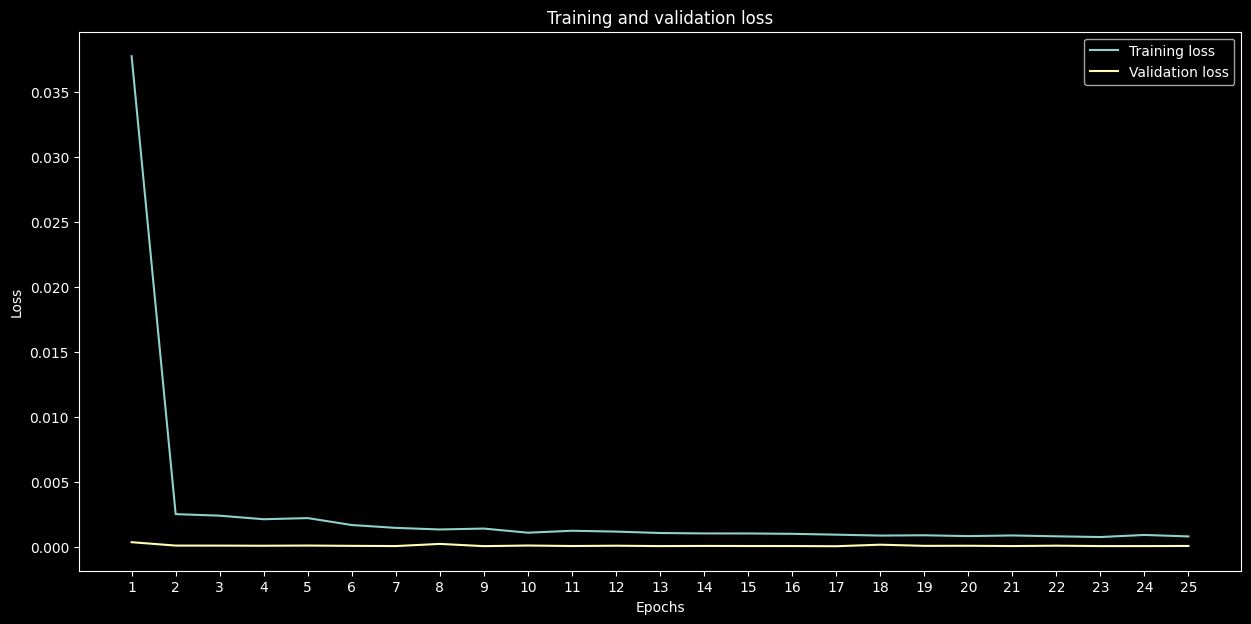

In [12]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values)+1)
plt.plot(epochs, loss_values, label='Training loss')
plt.plot(epochs, val_loss_values, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.xticks(epochs)
fig = plt.gcf()
fig.set_size_inches(15,7)
plt.show()

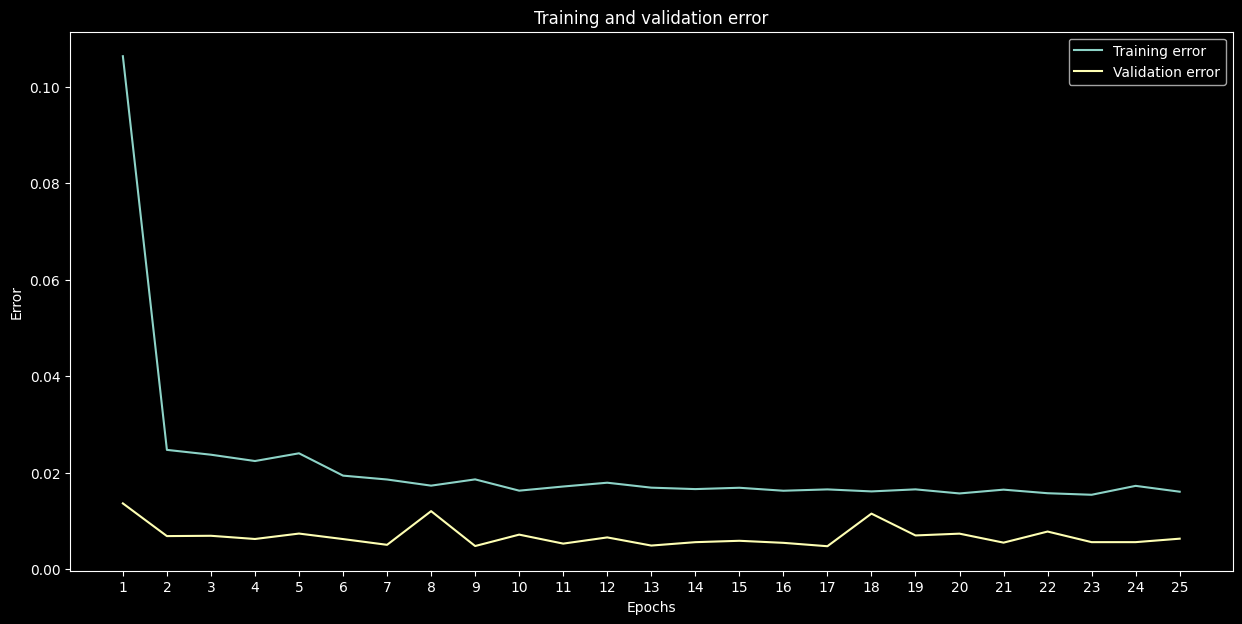

In [13]:
mae = history_dict['mae']
val_mae = history_dict['val_mae']
plt.plot(epochs, mae, label='Training error')
plt.plot(epochs, val_mae, label='Validation error')
plt.title('Training and validation error')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.xticks(epochs)
fig = plt.gcf()
fig.set_size_inches(15,7)
plt.show()

In [14]:
# Predict X_train and X_val
p_train = model.predict(X_train)
p_train = sc_train.inverse_transform(p_train)
p_val = model.predict(X_val)
p_val = sc_train.inverse_transform(p_val)

124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


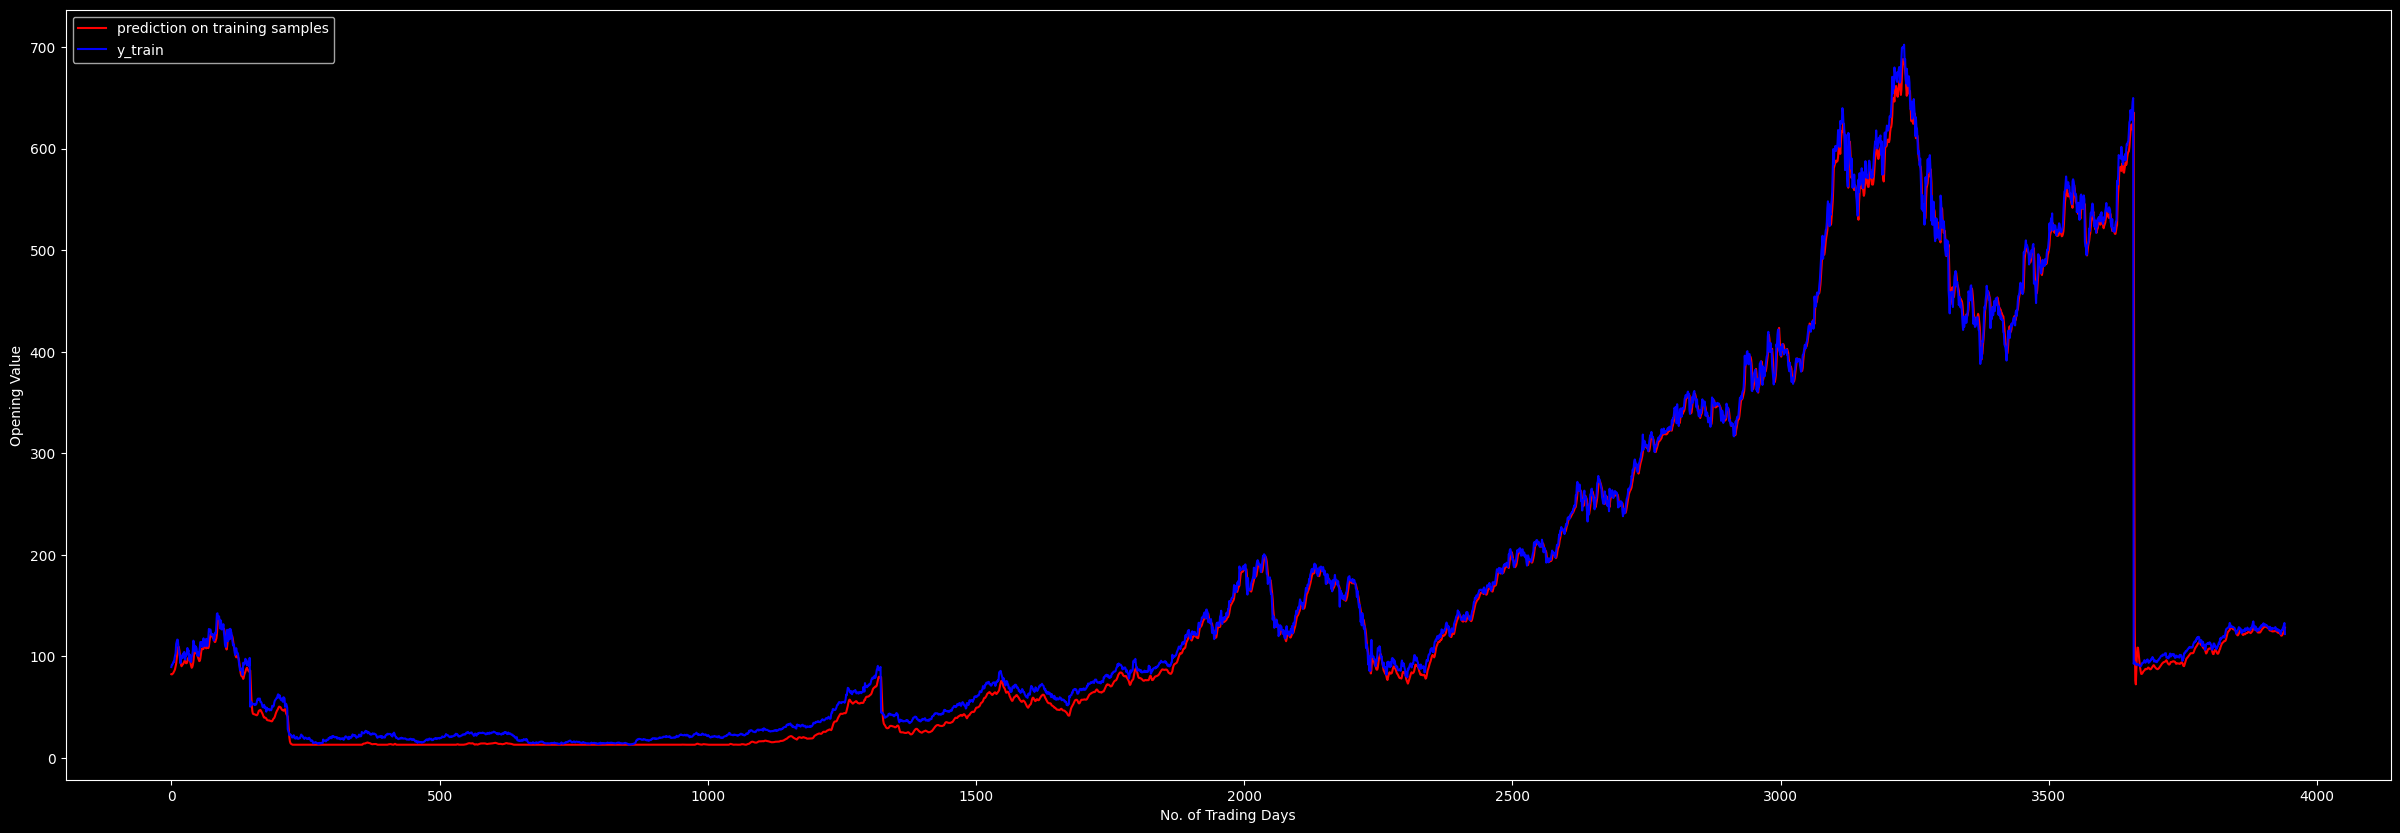

In [15]:
# Compare p_train and y_train
plt.plot(p_train, color='red', label='prediction on training samples')
plt.plot(sc_train.inverse_transform(y_train.reshape((-1, 1))), color='blue', label='y_train')
plt.xlabel('No. of Trading Days')
plt.ylabel('Opening Value')
plt.legend(loc='upper left')
fig = plt.gcf()
fig.set_size_inches(30,10)
plt.show()

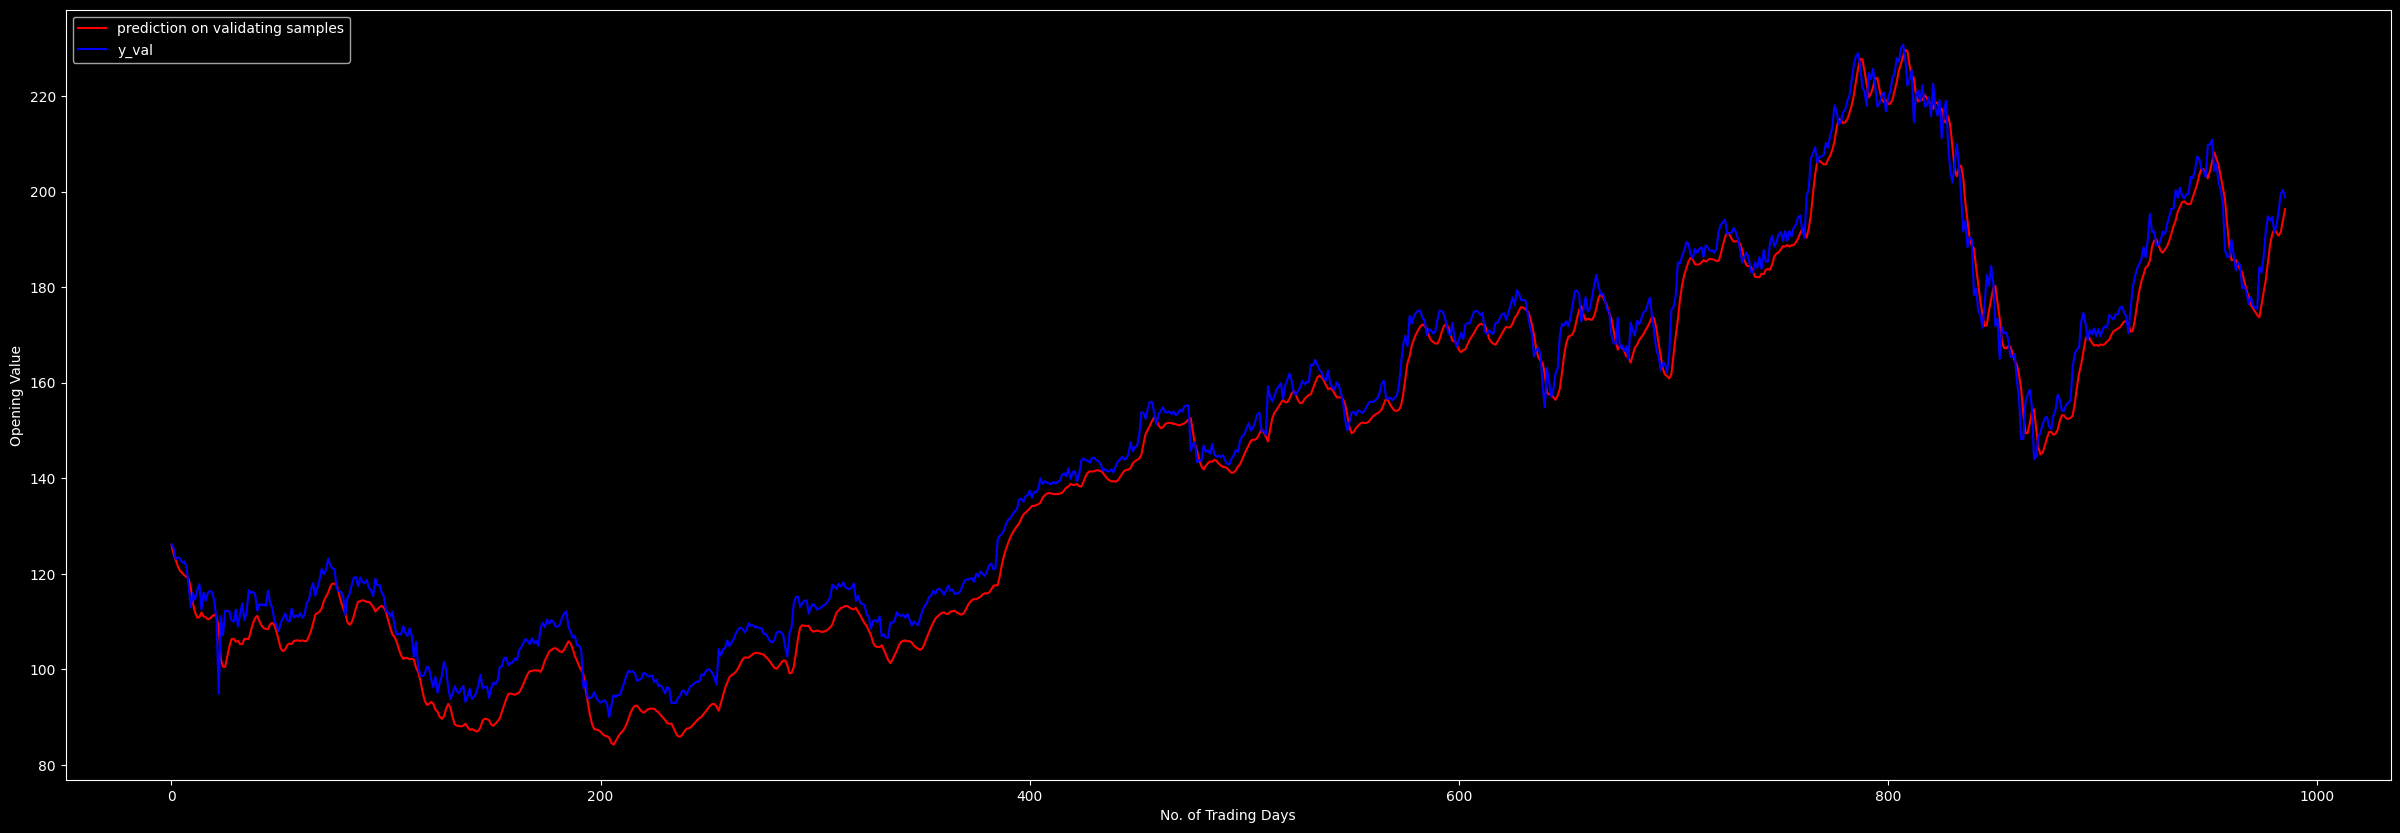

In [16]:
# Compare p_val and y_val
plt.plot(p_val, color='red', label='prediction on validating samples')
plt.plot(sc_train.inverse_transform(y_val.reshape((-1, 1))), color='blue', label='y_val')
plt.xlabel('No. of Trading Days')
plt.ylabel('Opening Value')
plt.legend(loc='upper left')
fig = plt.gcf()
fig.set_size_inches(30,10)
plt.show()

## Prediction on Testing Dataset

In [17]:
# Scale test set
sc_test = MinMaxScaler()
testing_set = sc_test.fit_transform(testing_set)

# Get X and y from testing set
X_test, y_test = get_x_y(testing_set, 14, 0, 1)
print("X_test: ", X_test.shape)
print("y_test: ", y_test.shape)

X_test:  (1222, 14, 1)
y_test:  (1222,)


In [18]:
# Predict X_test
p_test = model.predict(X_test)
p_test = sc_test.inverse_transform(p_test)

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


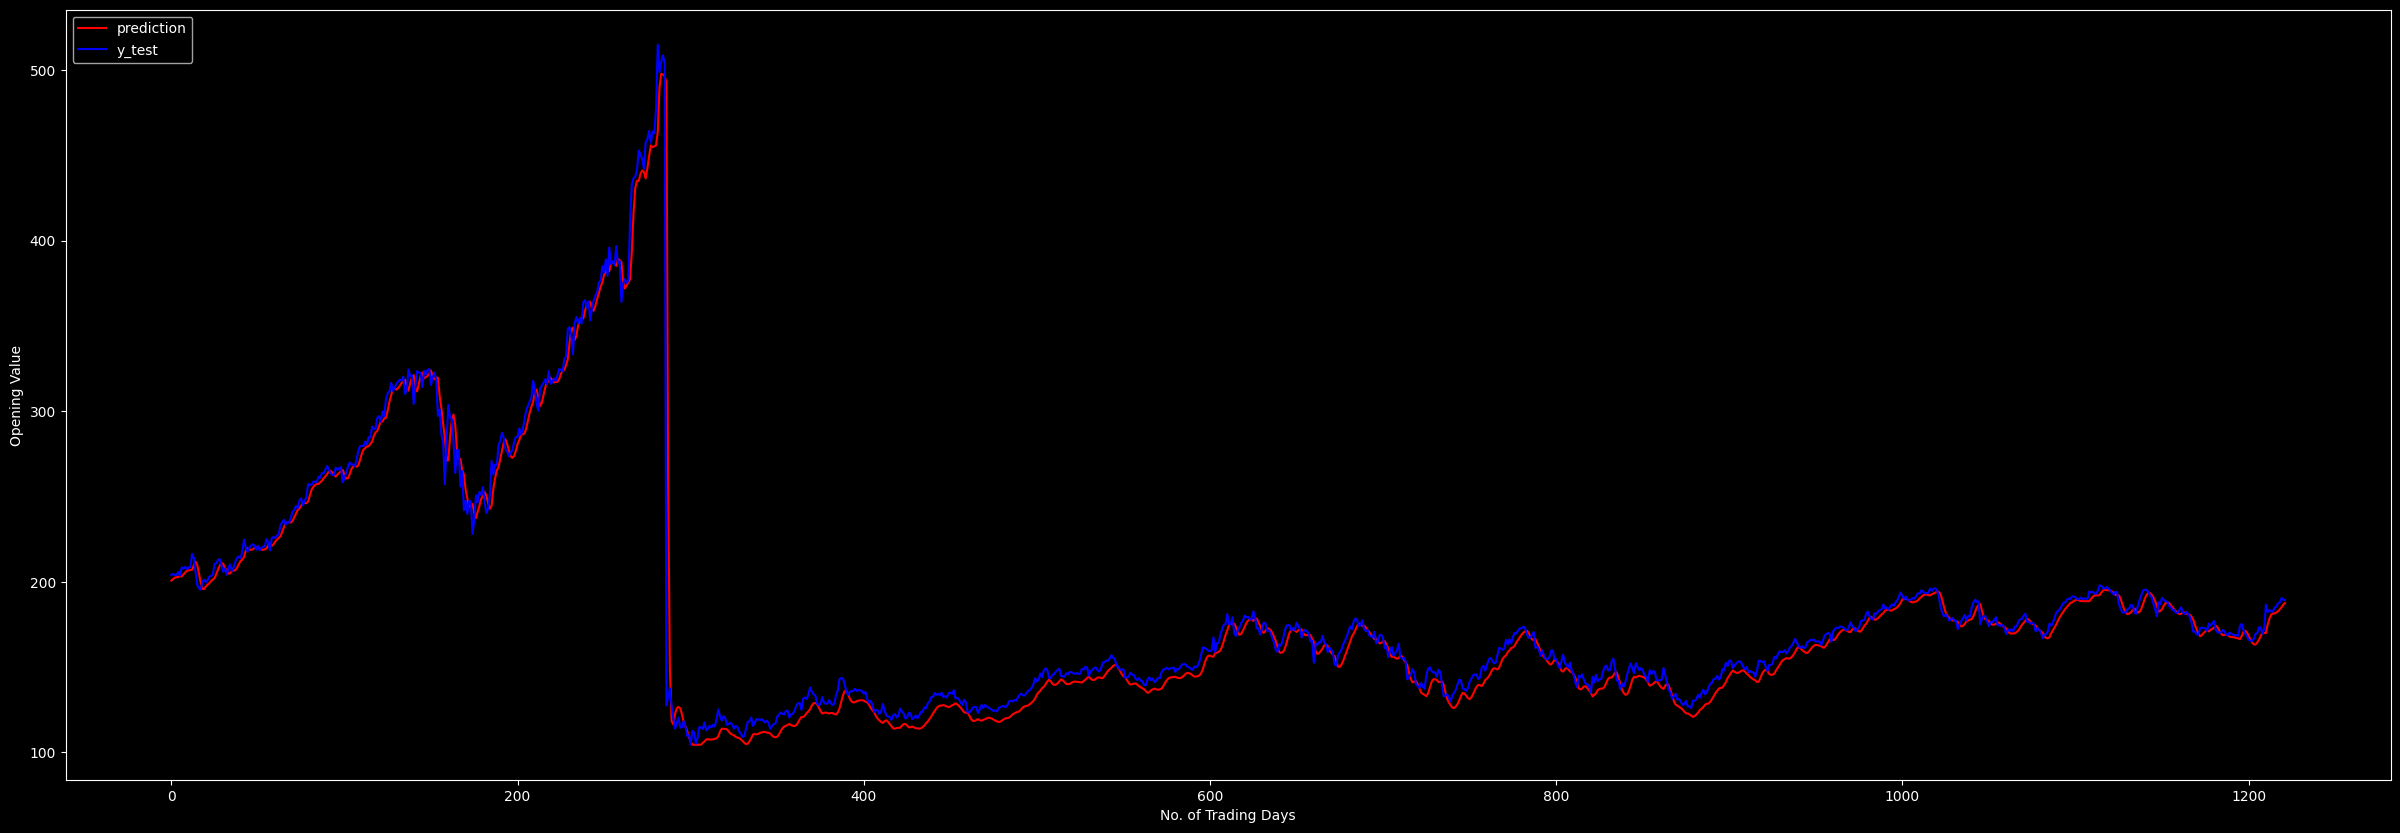

In [19]:
# Compare prediction vs y_test
plt.plot(p_test,color='red', label='prediction')
plt.plot(sc_test.inverse_transform(y_test.reshape((-1, 1))),color='blue', label='y_test')
plt.xlabel('No. of Trading Days')
plt.ylabel('Opening Value')
plt.legend(loc='upper left')
fig = plt.gcf()
fig.set_size_inches(30, 10)
plt.show()

## More Model Evaluation

In [20]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014 - mae: 0.0150    
test loss, test acc: [0.0009915503906086087, 0.013594199903309345]


In [21]:
#adding empirical mae

from sklearn.metrics import mean_absolute_error
denomarlized_ytest = sc_test.inverse_transform(y_test.reshape((-1, 1)))
mae = mean_absolute_error(denomarlized_ytest, p_test)
mae_percentage = (mae / np.mean(denomarlized_ytest)) * 100
print("Mean absolute error on test set: {:.2f}%".format(mae_percentage))

Mean absolute error on test set: 2.98%


In [22]:
# r2 score
from sklearn.metrics import r2_score

# Actual values
actual = denomarlized_ytest

# Predicted values
predicted = p_test

# Calculate the R2 score
r2 = r2_score(actual, predicted)

print("R2 score:", r2)

R2 score: 0.9657741946997996


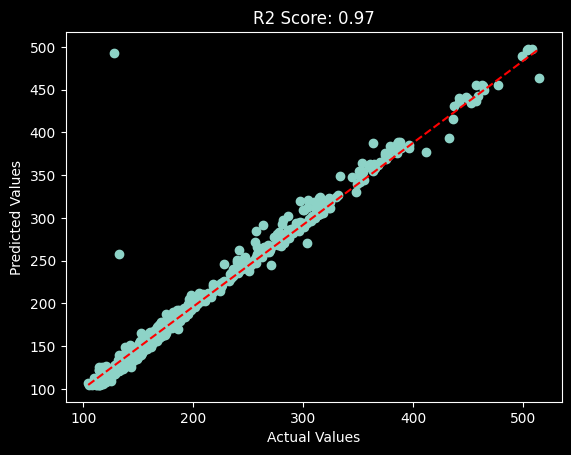

In [23]:
plt.scatter(actual, predicted)
plt.plot([min(actual), max(actual)], [min(predicted), max(predicted)], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'R2 Score: {r2:.2f}')
plt.show()

# With Sentiment

## Data Preprocessing

In [87]:
BERT_sent_data = pd.read_csv('data/4.12.15-5.11.24_BERT_sentiments.csv')
# VADER_sent_data = pd.read_csv('data/4.12.15-5.11.24_VADER_sentiments.csv')

In [25]:
BERT_data = pd.merge(data, BERT_sent_data, left_on='timestamp', right_on='date')
BERT_data

,timestamp,open,high,low,close,volume,date,article_titles,sentiment
0,2015-04-14,127.000,127.290,125.91,126.30,25524593,2015-04-14,"['Will The $17,000 Apple Watch Inspire A $20,0...",-0.5197
1,2015-04-15,126.410,127.130,126.01,126.78,28970419,2015-04-15,['6% Of US Adults Plan To Purchase Apple Watch...,-0.7127
2,2015-04-17,125.550,126.140,124.46,124.75,51957046,2015-04-17,['Apple Offers Workshops For Users To Get Acqu...,-0.2263
3,2015-04-20,125.570,128.120,125.17,127.60,47054310,2015-04-20,"['2 Apple Charts This Expert Is Tracking', ""Wh...",-0.2338
4,2015-04-21,128.100,128.200,126.67,126.91,32435057,2015-04-21,"[""Yahoo's Earnings Prospects Fail To Excite An...",-0.2340
...,...,...,...,...,...,...,...,...,...
1558,2024-05-02,172.510,173.415,170.89,173.03,94214915,2024-05-02,['Apple CEO Tim Cook Says iPhone Grew In Mainl...,-0.1288
1559,2024-05-03,186.645,187.000,182.66,183.38,163224109,2024-05-03,"['Canaccord Genuity Maintains Buy on Apple, Ra...",-0.3865
1560,2024-05-06,182.354,184.200,180.42,181.71,78569667,2024-05-06,"['Thanks To Apple, This Analyst Is Optimistic ...",-0.0173
1561,2024-05-08,182.850,183.070,181.45,182.74,45057087,2024-05-08,['Apple Reverses Sales Decline in China with I...,-0.5756


In [26]:
# Split data into training and testing
training_set, testing_set = split_data(BERT_data, 0.85, ['open', 'sentiment'])
print("training_set: ", training_set.shape)
print("testing_set: ", testing_set.shape)

training_set:  (1328, 2)
testing_set:  (235, 2)


In [27]:
# Scale training set open
from sklearn.preprocessing import MinMaxScaler
sc_train = MinMaxScaler()
training_set[:, 0] = sc_train.fit_transform(training_set[:, 0].reshape((-1,1))).reshape((-1))
training_set[:5]

array([[ 0.08121876, -0.5197    ],
       [ 0.07982088, -0.7127    ],
       [ 0.07778331, -0.2263    ],
       [ 0.07783069, -0.2338    ],
       [ 0.08382496, -0.234     ]])

In [28]:
# Get X and y from training set
X_train, y_train = get_x_y(training_set, 14, 0, 2)

# Split training into train and val
val_split_row = int(X_train.shape[0]*0.85) # 15% will be used for validation
X_train, X_val = X_train[:val_split_row], X_train[val_split_row:]
y_train, y_val = y_train[:val_split_row], y_train[val_split_row:]
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_val: ", X_val.shape)
print("y_val: ", y_val.shape)

X_train:  (1116, 14, 2)
y_train:  (1116,)
X_val:  (198, 14, 2)
y_val:  (198,)


## LTSM Model and Training

In [29]:
model = build_model(14, 2)
print(model.summary())

C:\Users\blkeu\anaconda3\envs\CS172B311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 14, 128)             │          67,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 32)                  │          20,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 88,225 (344.63 KB)

 Trainable params: 88,225 (344.63 KB)

 Non-trainable params: 0 (0.00 B)

None


In [30]:
# # Save weights only for best model
# checkpointer = ModelCheckpoint(
#     filepath = 'weights_best.pth',
#     verbose = 2,
#     save_best_only = True
# )


history = model.fit(X_train,
                    y_train,
                    batch_size=32,
                    epochs=25,
                    validation_data=(X_val, y_val),
                    verbose =2)
                    # callbacks = [checkpointer])

Epoch 1/25
35/35 - 2s - 71ms/step - loss: 0.0386 - mae: 0.1370 - val_loss: 0.0013 - val_mae: 0.0305
Epoch 2/25
35/35 - 0s - 7ms/step - loss: 0.0228 - mae: 0.1013 - val_loss: 0.0036 - val_mae: 0.0501
Epoch 3/25
35/35 - 0s - 7ms/step - loss: 0.0064 - mae: 0.0426 - val_loss: 0.0024 - val_mae: 0.0426
Epoch 4/25
35/35 - 0s - 7ms/step - loss: 0.0057 - mae: 0.0397 - val_loss: 7.7424e-04 - val_mae: 0.0235
Epoch 5/25
35/35 - 0s - 7ms/step - loss: 0.0052 - mae: 0.0365 - val_loss: 4.5399e-04 - val_mae: 0.0177
Epoch 6/25
35/35 - 0s - 8ms/step - loss: 0.0043 - mae: 0.0311 - val_loss: 6.5492e-04 - val_mae: 0.0218
Epoch 7/25
35/35 - 0s - 8ms/step - loss: 0.0033 - mae: 0.0288 - val_loss: 3.6102e-04 - val_mae: 0.0159
Epoch 8/25
35/35 - 0s - 9ms/step - loss: 0.0027 - mae: 0.0267 - val_loss: 3.4297e-04 - val_mae: 0.0154
Epoch 9/25
35/35 - 0s - 8ms/step - loss: 0.0023 - mae: 0.0252 - val_loss: 4.7910e-04 - val_mae: 0.0182
Epoch 10/25
35/35 - 0s - 7ms/step - loss: 0.0023 - mae: 0.0256 - val_loss: 3.1149e-0

## Model Evaluation

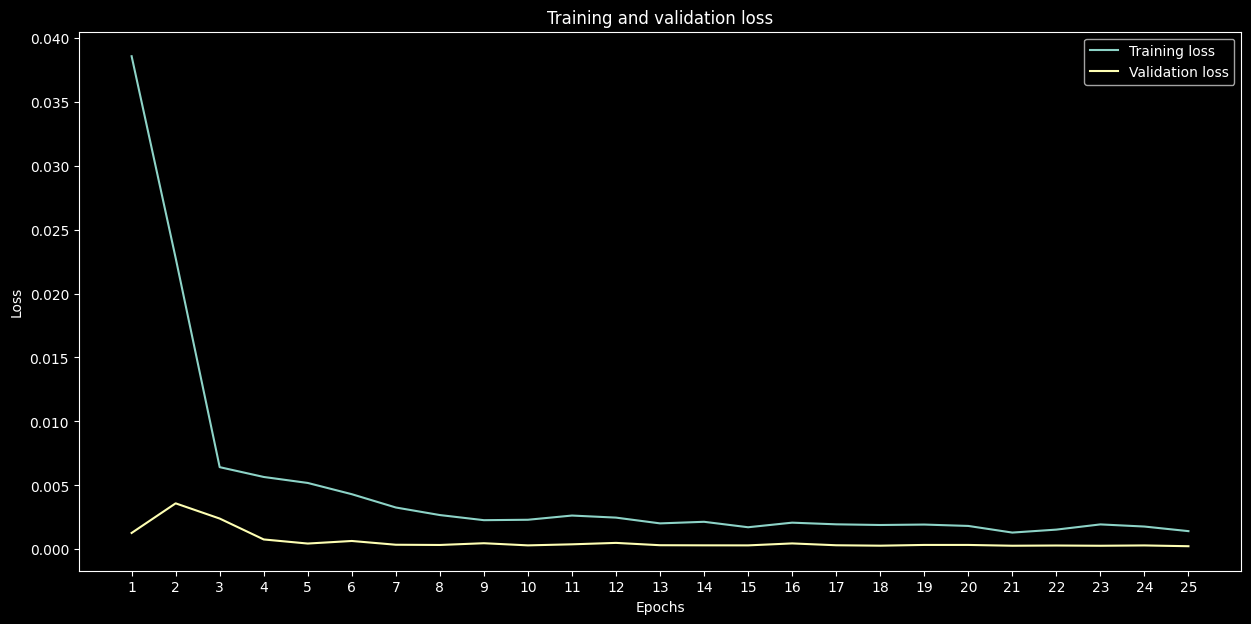

In [31]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values)+1)
plt.plot(epochs, loss_values, label='Training loss')
plt.plot(epochs, val_loss_values, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.xticks(epochs)
fig = plt.gcf()
fig.set_size_inches(15,7)
plt.show()

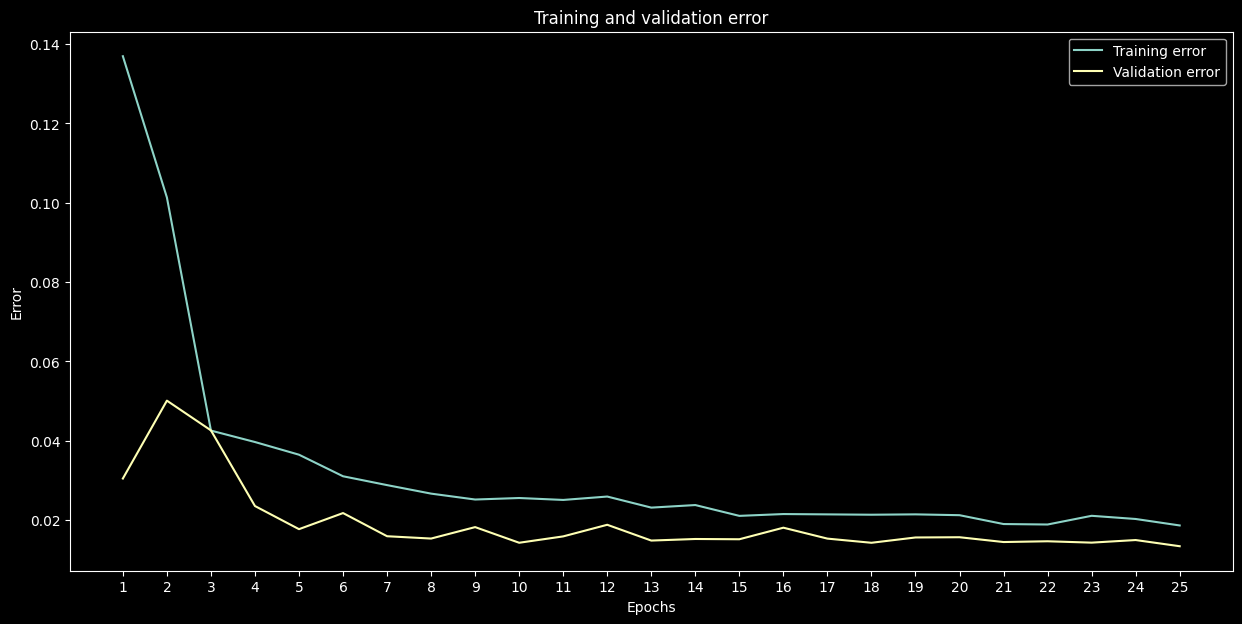

In [32]:
mae = history_dict['mae']
val_mae = history_dict['val_mae']
plt.plot(epochs, mae, label='Training error')
plt.plot(epochs, val_mae, label='Validation error')
plt.title('Training and validation error')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.xticks(epochs)
fig = plt.gcf()
fig.set_size_inches(15,7)
plt.show()

In [33]:
# Predict X_train and X_val
p_train = model.predict(X_train)
p_train = sc_train.inverse_transform(p_train)
p_val = model.predict(X_val)
p_val = sc_train.inverse_transform(p_val)

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


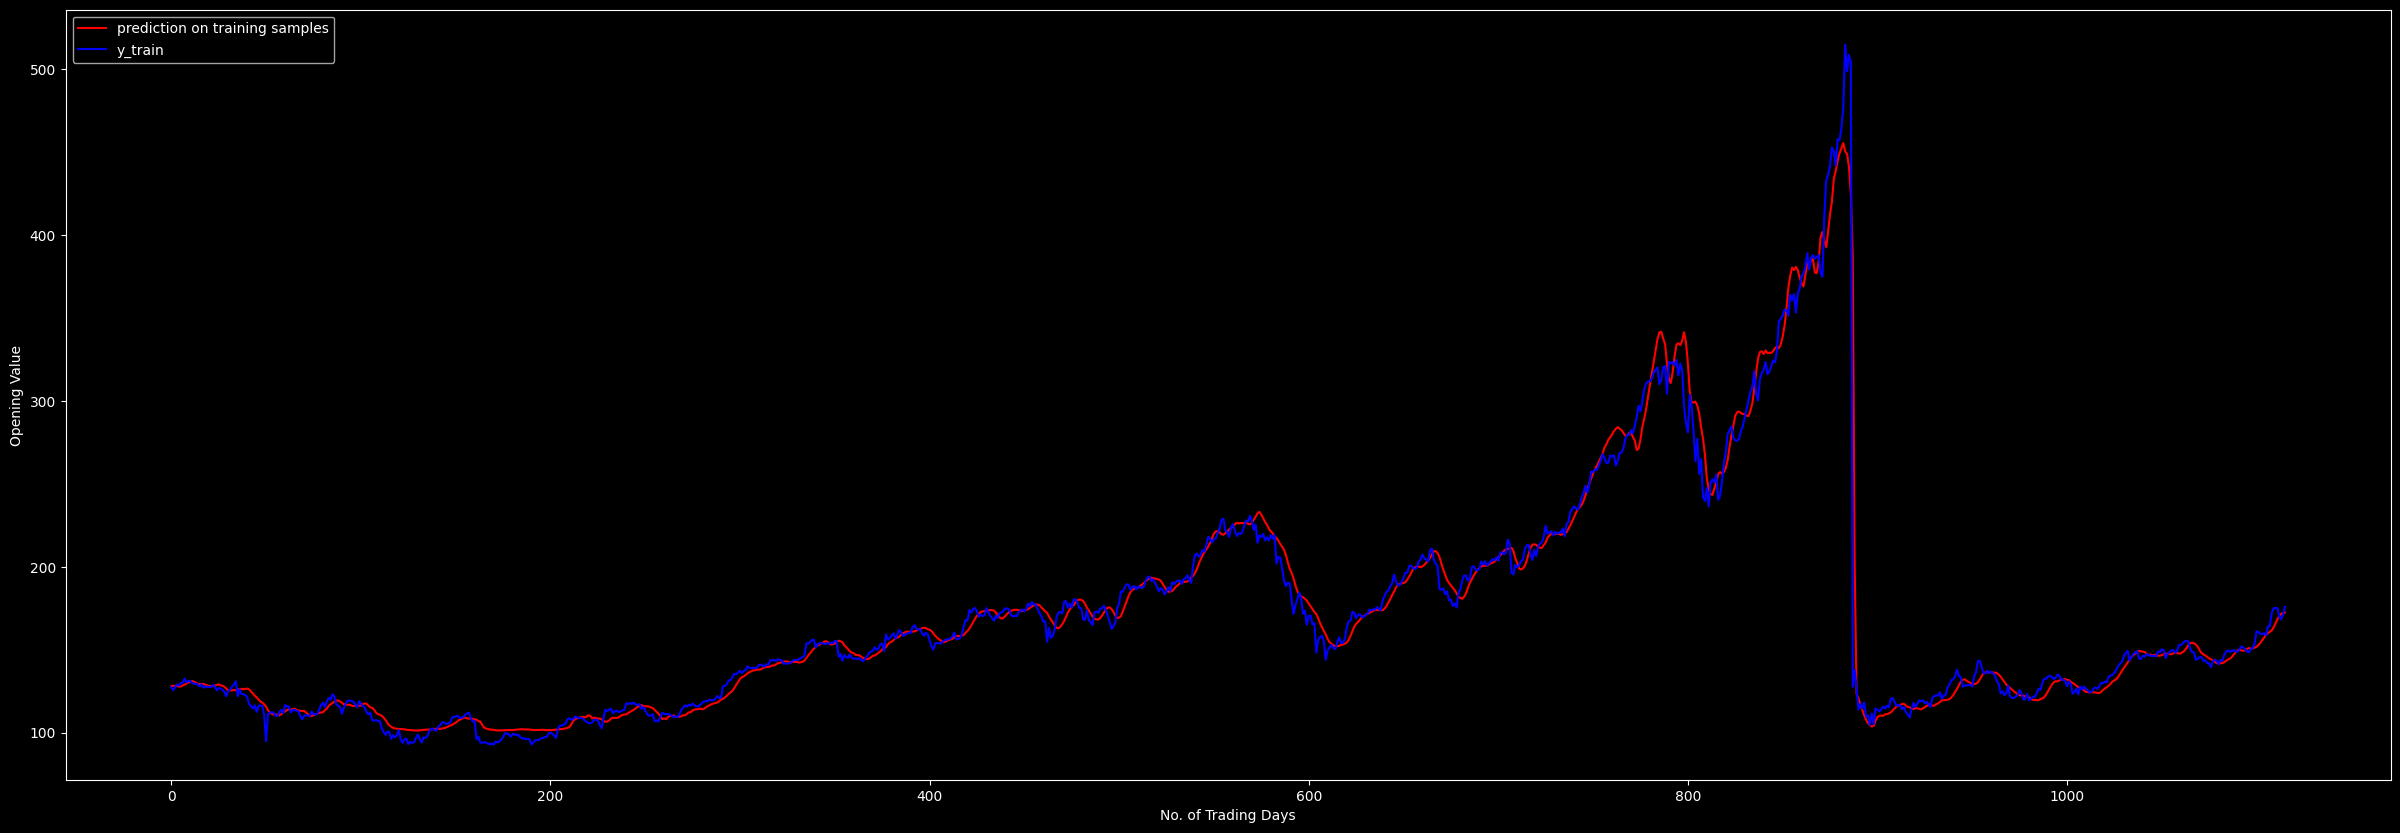

In [34]:
# Compare p_train and y_train
plt.plot(p_train, color='red', label='prediction on training samples')
plt.plot(sc_train.inverse_transform(y_train.reshape((-1, 1))), color='blue', label='y_train')
plt.xlabel('No. of Trading Days')
plt.ylabel('Opening Value')
plt.legend(loc='upper left')
fig = plt.gcf()
fig.set_size_inches(30,10)
plt.show()

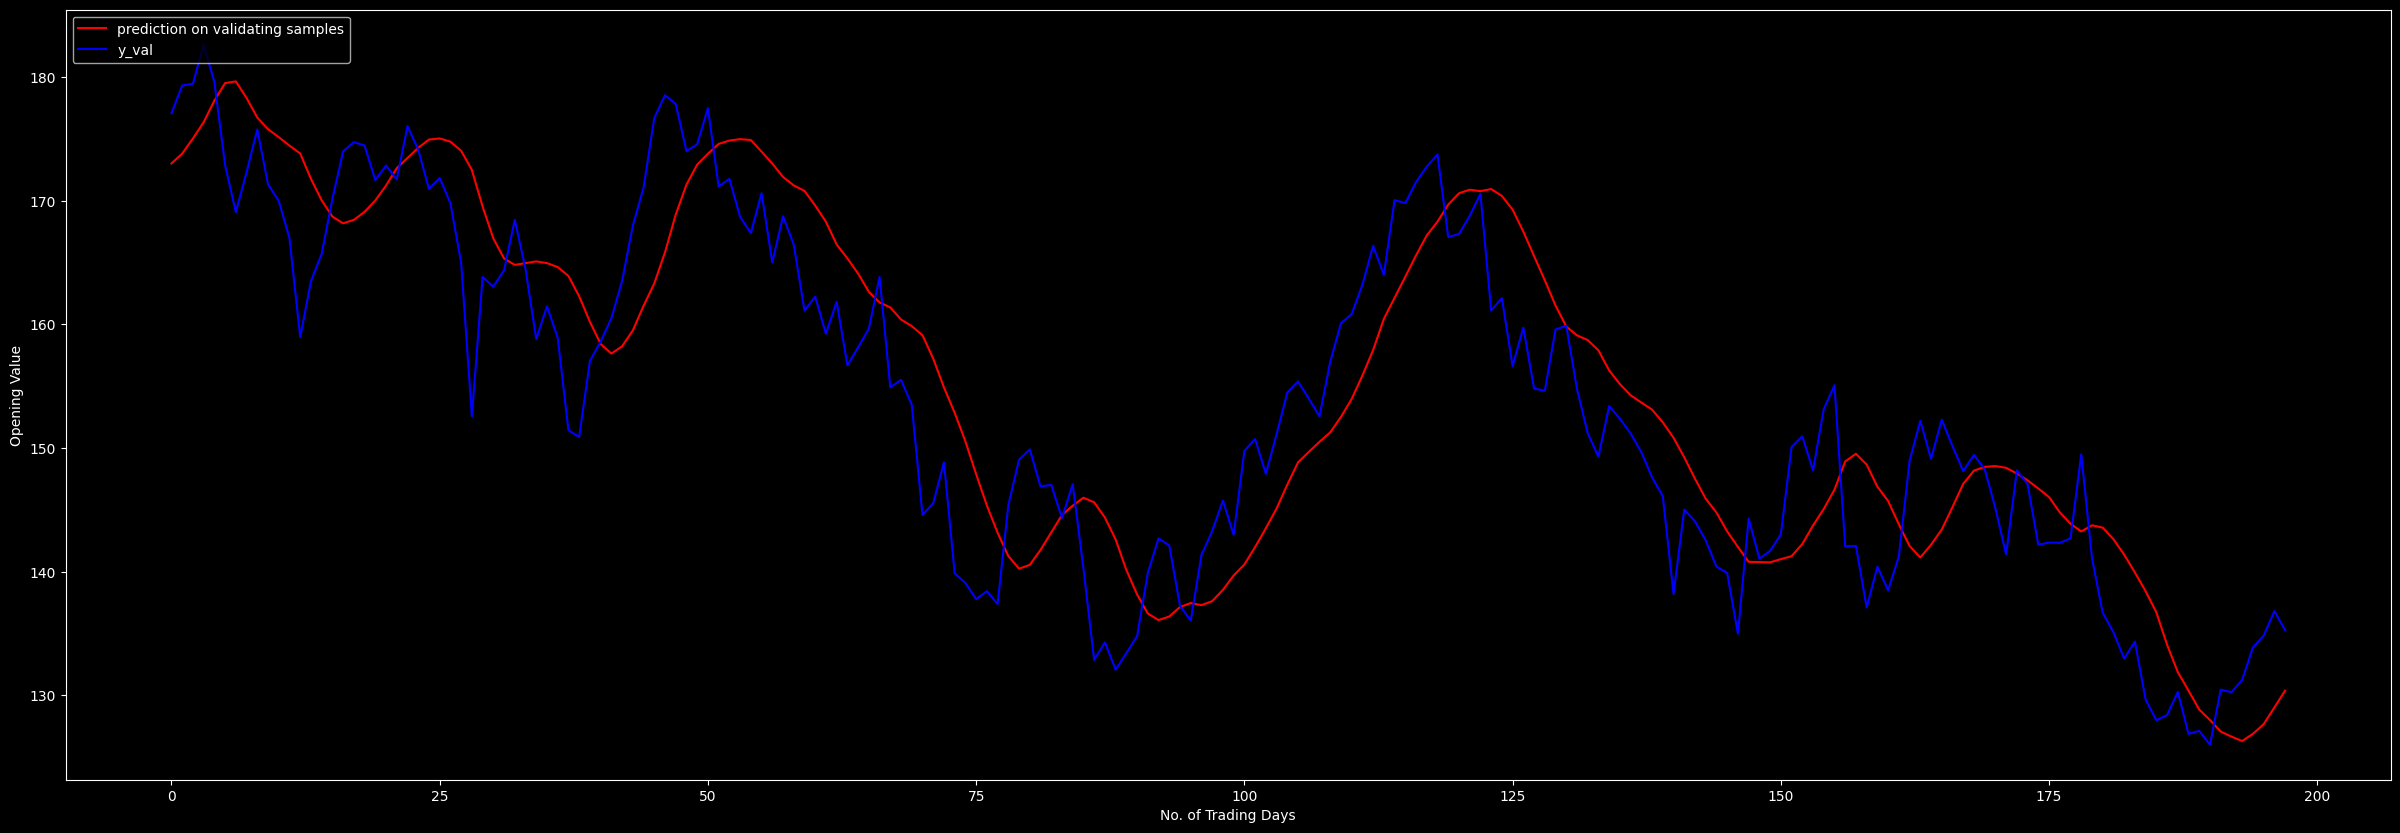

In [35]:
# Compare p_val and y_val
plt.plot(p_val, color='red', label='prediction on validating samples')
plt.plot(sc_train.inverse_transform(y_val.reshape((-1, 1))), color='blue', label='y_val')
plt.xlabel('No. of Trading Days')
plt.ylabel('Opening Value')
plt.legend(loc='upper left')
fig = plt.gcf()
fig.set_size_inches(30,10)
plt.show()

## Prediction on Testing Dataset

In [36]:
# Scale training set open
sc_test = MinMaxScaler()
testing_set[:, 0] = sc_test.fit_transform(testing_set[:, 0].reshape((-1,1))).reshape((-1))

# Get X and y from training set
X_test, y_test = get_x_y(testing_set, 14, 0, 2)
print("X_test: ", X_test.shape)
print("y_test: ", y_test.shape)

X_test:  (221, 14, 2)
y_test:  (221,)


In [37]:
# Predict X_test
p_test = model.predict(X_test)
p_test = sc_test.inverse_transform(p_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


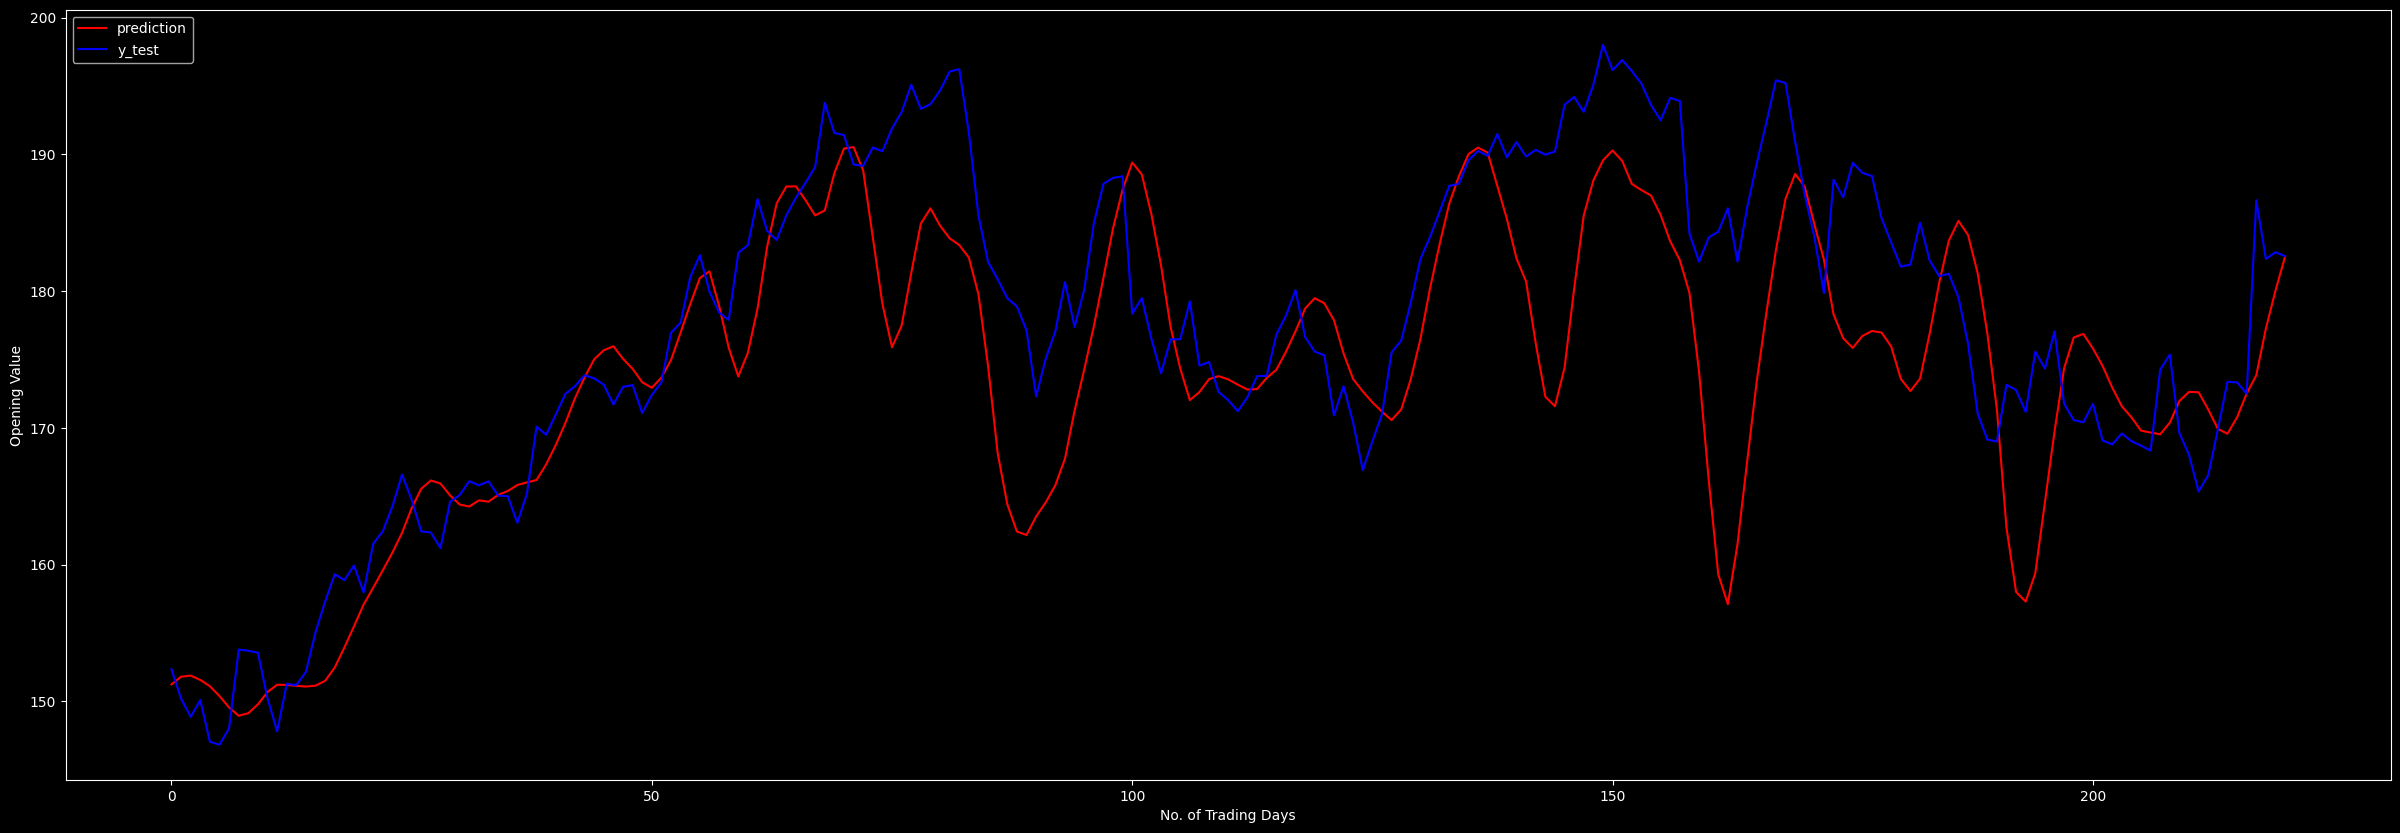

In [38]:
# Compare prediction vs y_test
plt.plot(p_test,color='red', label='prediction')
plt.plot(sc_test.inverse_transform(y_test.reshape((-1, 1))),color='blue', label='y_test')
plt.xlabel('No. of Trading Days')
plt.ylabel('Opening Value')
plt.legend(loc='upper left')
fig = plt.gcf()
fig.set_size_inches(30, 10)
plt.show()

## More Model Evaluation

In [39]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0112 - mae: 0.0760 
test loss, test acc: [0.01653469167649746, 0.09559091925621033]


In [40]:
#adding empirical mae

from sklearn.metrics import mean_absolute_error
denomarlized_ytest = sc_test.inverse_transform(y_test.reshape((-1, 1)))
mae = mean_absolute_error(denomarlized_ytest, p_test)
mae_percentage = (mae / np.mean(denomarlized_ytest)) * 100
print("Mean absolute error on test set: {:.2f}%".format(mae_percentage))

Mean absolute error on test set: 3.23%


In [41]:
# r2 score
from sklearn.metrics import r2_score

# Actual values
actual = denomarlized_ytest

# Predicted values
predicted = p_test

# Calculate the R2 score
r2 = r2_score(actual, predicted)

print("R2 score:", r2)

R2 score: 0.5931149330608367


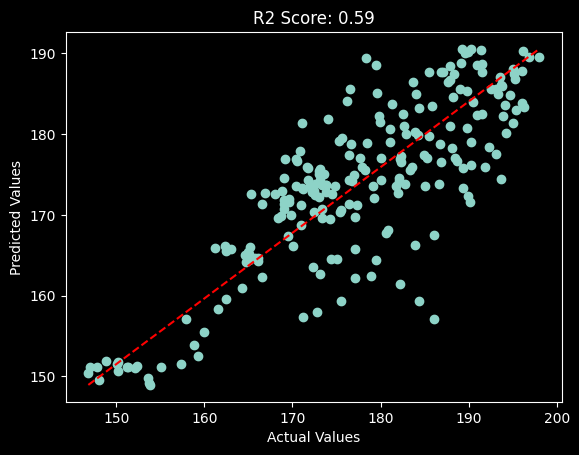

In [42]:
plt.scatter(actual, predicted)
plt.plot([min(actual), max(actual)], [min(predicted), max(predicted)], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'R2 Score: {r2:.2f}')
plt.show()

# With Sentiment - Missing Sentiment Scores have Average of Nearest 2 Days - All Time Dataset

## Data Preprocessing

In [44]:
BERT_sent_data = pd.read_csv('data/4.12.15-5.11.24_BERT_sentiments.csv')

In [45]:
# Merge data on dates
merged_data = pd.merge(data, BERT_sent_data, left_on='timestamp', right_on='date', how='left')

# Sort by date to ensure correct order
merged_data['timestamp'] = pd.to_datetime(merged_data['timestamp'])
merged_data.sort_values('timestamp', inplace=True)

# Fill NaN dates with corresponding timestamps
merged_data['date'] = merged_data['date'].fillna(merged_data['timestamp'])

# Interpolate missing sentiment scores
merged_data['sentiment'] = merged_data['sentiment'].interpolate(method='nearest')

# Fill any remaining missing sentiment values with forward fill and backward fill
merged_data['sentiment'] = merged_data['sentiment'].fillna(method='ffill').fillna(method='bfill')

# Remove the column "article_titles"
merged_data = merged_data.drop(columns=['article_titles'])

merged_data

C:\Users\blkeu\AppData\Local\Temp\ipykernel_34672\1283586907.py:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_data['sentiment'] = merged_data['sentiment'].fillna(method='ffill').fillna(method='bfill')


,timestamp,open,high,low,close,volume,date,sentiment
0,1999-11-01,80.000,80.6900,77.3700,77.62,2487300,1999-11-01 00:00:00,-0.5197
1,1999-11-02,78.000,81.6900,77.3100,80.25,3564600,1999-11-02 00:00:00,-0.5197
2,1999-11-03,81.620,83.2500,81.0000,81.50,2932700,1999-11-03 00:00:00,-0.5197
3,1999-11-04,82.060,85.3700,80.6200,83.62,3384700,1999-11-04 00:00:00,-0.5197
4,1999-11-05,84.620,88.3700,84.0000,88.31,3721500,1999-11-05 00:00:00,-0.5197
...,...,...,...,...,...,...,...,...
6172,2024-05-14,187.510,188.3000,186.2900,187.43,52393619,2024-05-14 00:00:00,-0.8515
6173,2024-05-15,187.910,190.6500,187.3700,189.72,70399988,2024-05-15 00:00:00,-0.8515
6174,2024-05-16,190.470,191.0950,189.6601,189.84,52845230,2024-05-16 00:00:00,-0.8515
6175,2024-05-17,189.510,190.8100,189.1800,189.87,41282925,2024-05-17 00:00:00,-0.8515


In [46]:
# Split data into training and testing
training_set, testing_set = split_data(merged_data, 0.85, ['open', 'sentiment'])
print("training_set: ", training_set.shape)
print("testing_set: ", testing_set.shape)

training_set:  (5250, 2)
testing_set:  (927, 2)


In [47]:
# Scale training set open
from sklearn.preprocessing import MinMaxScaler
sc_train = MinMaxScaler()
training_set[:, 0] = sc_train.fit_transform(training_set[:, 0].reshape((-1,1))).reshape((-1))
training_set[:5]

array([[ 0.09719764, -0.5197    ],
       [ 0.09429666, -0.5197    ],
       [ 0.09954745, -0.5197    ],
       [ 0.10018566, -0.5197    ],
       [ 0.10389893, -0.5197    ]])

In [48]:
# Get X and y from training set
X_train, y_train = get_x_y(training_set, 14, 0, 2)

# Split training into train and val
val_split_row = int(X_train.shape[0]*0.85) # 15% will be used for validation
X_train, X_val = X_train[:val_split_row], X_train[val_split_row:]
y_train, y_val = y_train[:val_split_row], y_train[val_split_row:]
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_val: ", X_val.shape)
print("y_val: ", y_val.shape)

X_train:  (4450, 14, 2)
y_train:  (4450,)
X_val:  (786, 14, 2)
y_val:  (786,)


## LSTM Model and Training

In [49]:
model = build_model(14, 2)
print(model.summary())

C:\Users\blkeu\anaconda3\envs\CS172B311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 14, 128)             │          67,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 32)                  │          20,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 88,225 (344.63 KB)

 Trainable params: 88,225 (344.63 KB)

 Non-trainable params: 0 (0.00 B)

None


In [52]:
# # Save weights only for best model
# checkpointer = ModelCheckpoint(
#     filepath = 'weights_best.pth',
#     verbose = 2,
#     save_best_only = True
# )


history = model.fit(X_train,
                    y_train,
                    batch_size=32,
                    epochs=25,
                    validation_data=(X_val, y_val),
                    verbose =2,
                    # callbacks = [checkpointer]
                   )

Epoch 1/25
140/140 - 3s - 25ms/step - loss: 0.0216 - mae: 0.0822 - val_loss: 0.0055 - val_mae: 0.0461
Epoch 2/25
140/140 - 1s - 6ms/step - loss: 0.0025 - mae: 0.0289 - val_loss: 0.0023 - val_mae: 0.0203
Epoch 3/25
140/140 - 1s - 6ms/step - loss: 0.0021 - mae: 0.0242 - val_loss: 0.0024 - val_mae: 0.0253
Epoch 4/25
140/140 - 1s - 7ms/step - loss: 0.0017 - mae: 0.0212 - val_loss: 0.0020 - val_mae: 0.0189
Epoch 5/25
140/140 - 1s - 7ms/step - loss: 0.0018 - mae: 0.0212 - val_loss: 0.0023 - val_mae: 0.0197
Epoch 6/25
140/140 - 1s - 6ms/step - loss: 0.0016 - mae: 0.0193 - val_loss: 0.0017 - val_mae: 0.0181
Epoch 7/25
140/140 - 1s - 6ms/step - loss: 0.0014 - mae: 0.0186 - val_loss: 0.0018 - val_mae: 0.0165
Epoch 8/25
140/140 - 1s - 6ms/step - loss: 0.0014 - mae: 0.0186 - val_loss: 0.0014 - val_mae: 0.0166
Epoch 9/25
140/140 - 1s - 7ms/step - loss: 0.0012 - mae: 0.0184 - val_loss: 0.0014 - val_mae: 0.0150
Epoch 10/25
140/140 - 1s - 6ms/step - loss: 0.0011 - mae: 0.0158 - val_loss: 0.0011 - val_

## Model Evaluation

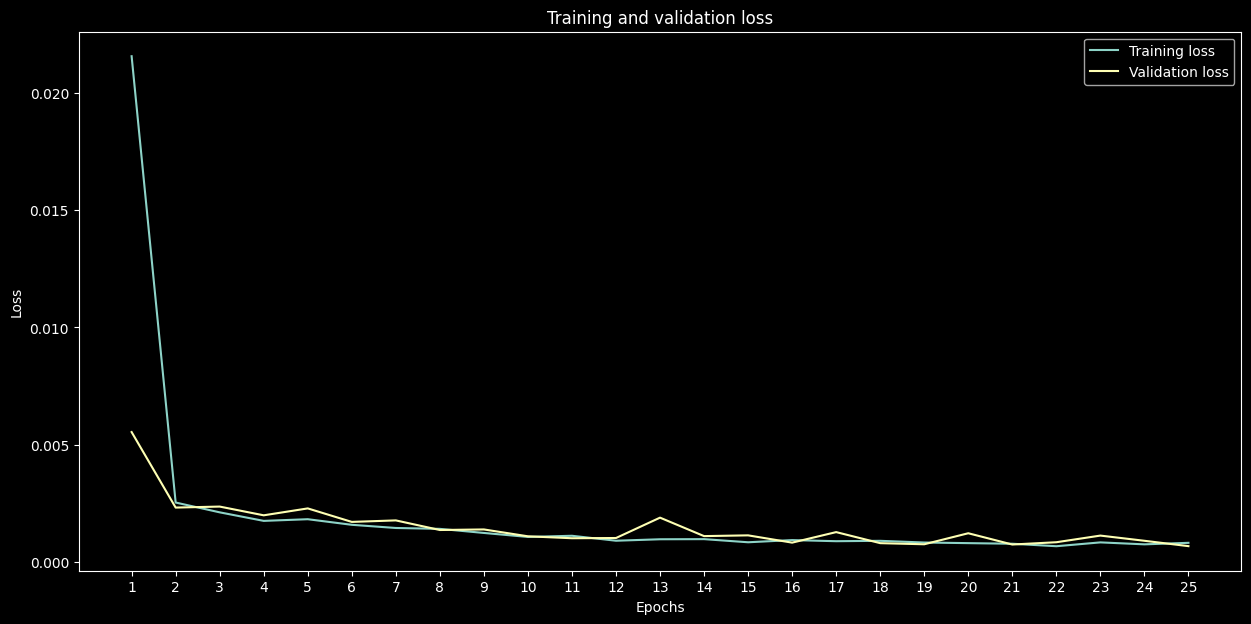

In [53]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values)+1)
plt.plot(epochs, loss_values, label='Training loss')
plt.plot(epochs, val_loss_values, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.xticks(epochs)
fig = plt.gcf()
fig.set_size_inches(15,7)
plt.show()

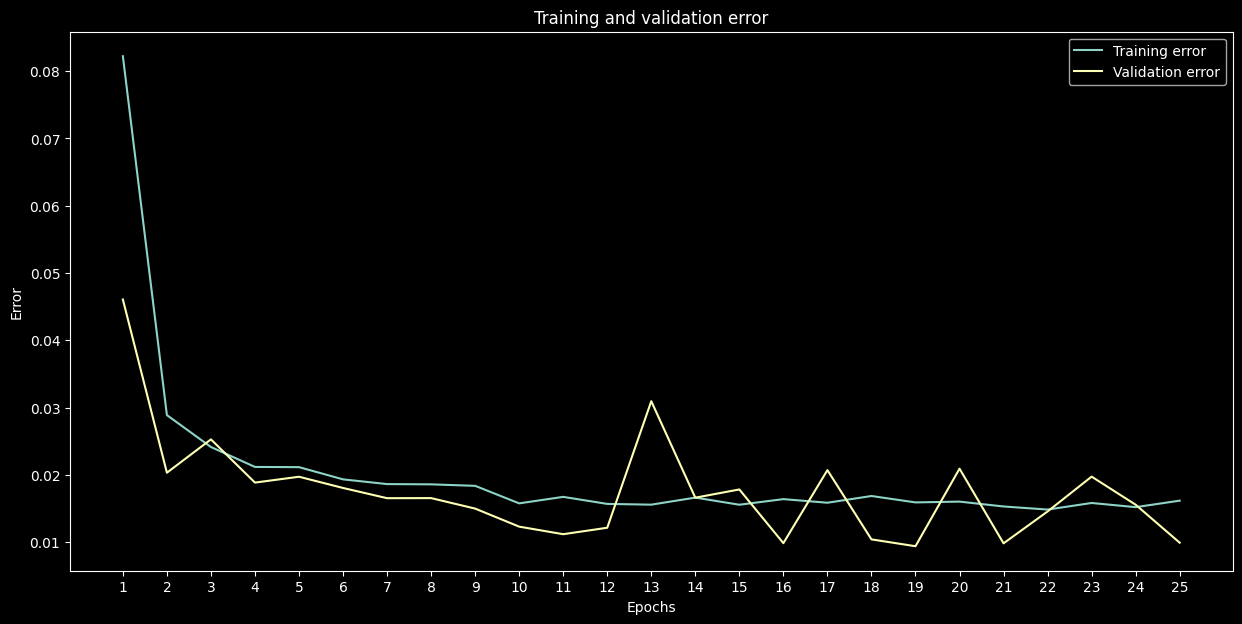

In [54]:
mae = history_dict['mae']
val_mae = history_dict['val_mae']
plt.plot(epochs, mae, label='Training error')
plt.plot(epochs, val_mae, label='Validation error')
plt.title('Training and validation error')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.xticks(epochs)
fig = plt.gcf()
fig.set_size_inches(15,7)
plt.show()

In [55]:
# Predict X_train and X_val
p_train = model.predict(X_train)
p_train = sc_train.inverse_transform(p_train)
p_val = model.predict(X_val)
p_val = sc_train.inverse_transform(p_val)

140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


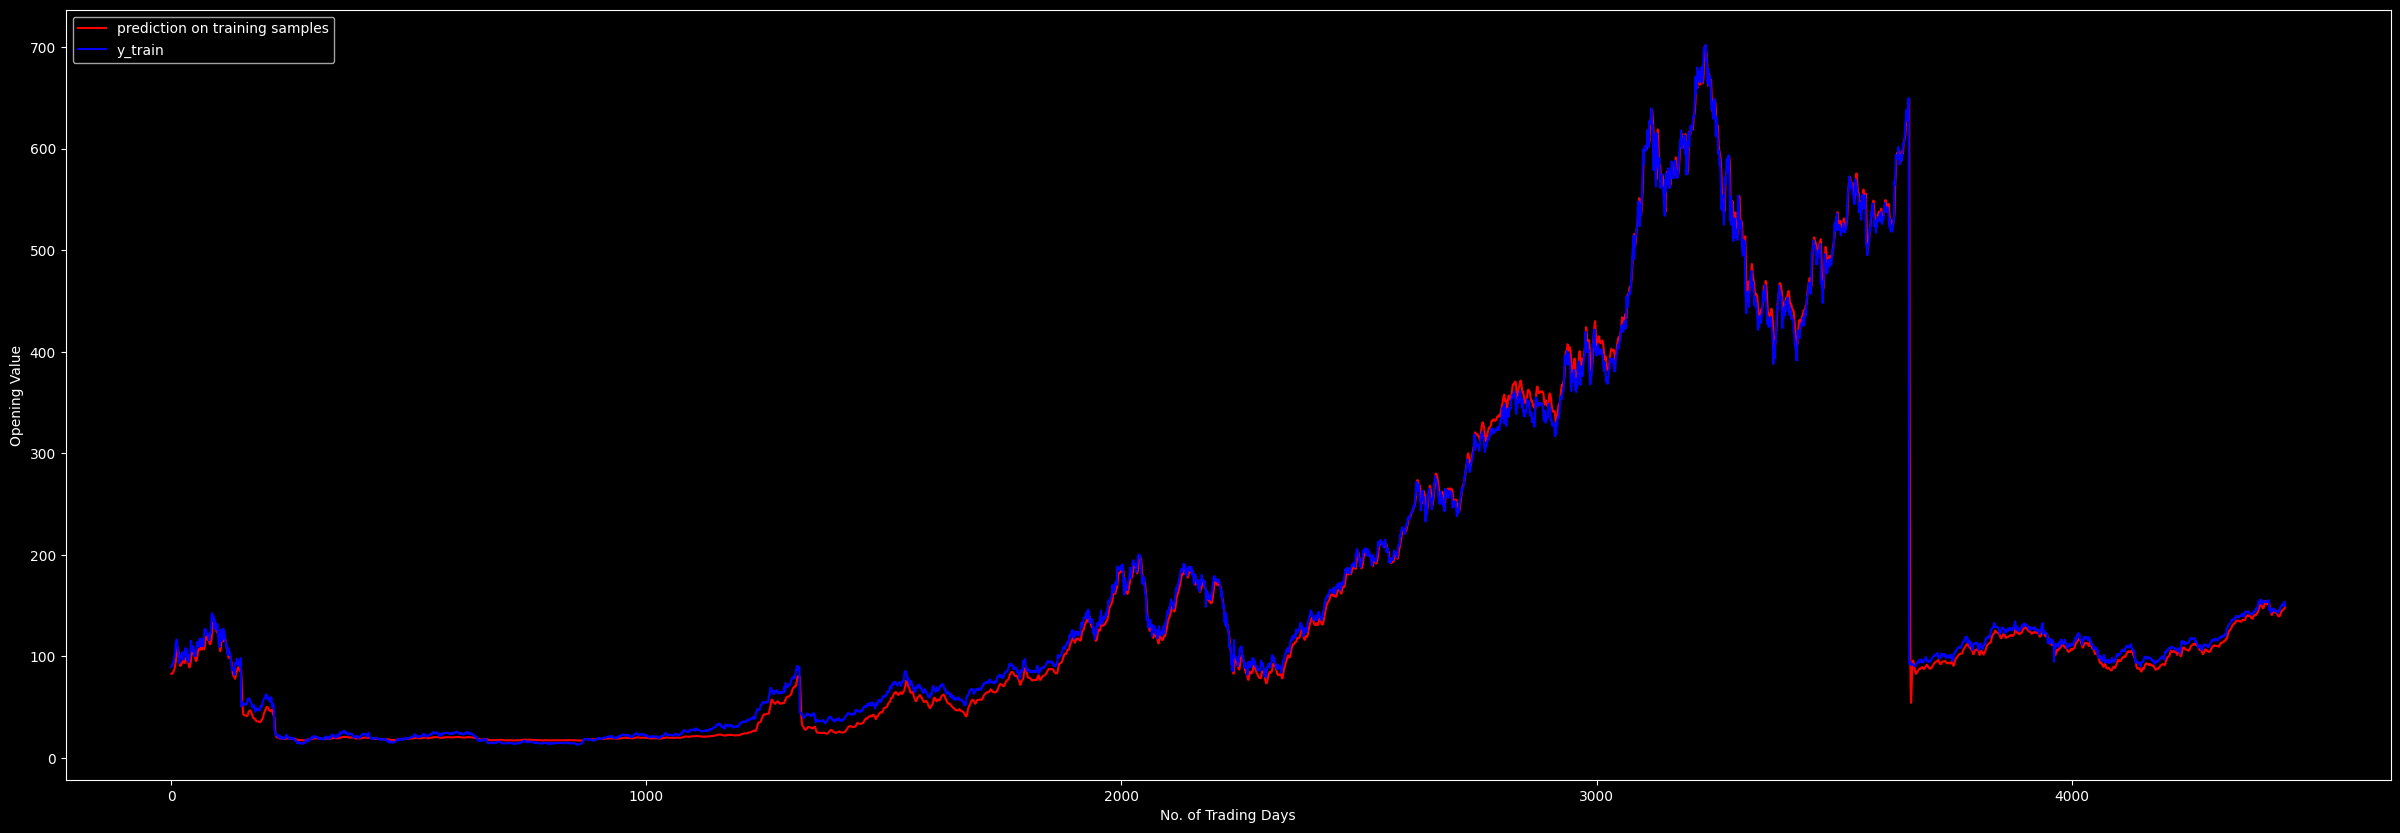

In [56]:
# Compare p_train and y_train
plt.plot(p_train, color='red', label='prediction on training samples')
plt.plot(sc_train.inverse_transform(y_train.reshape((-1, 1))), color='blue', label='y_train')
plt.xlabel('No. of Trading Days')
plt.ylabel('Opening Value')
plt.legend(loc='upper left')
fig = plt.gcf()
fig.set_size_inches(30,10)
plt.show()

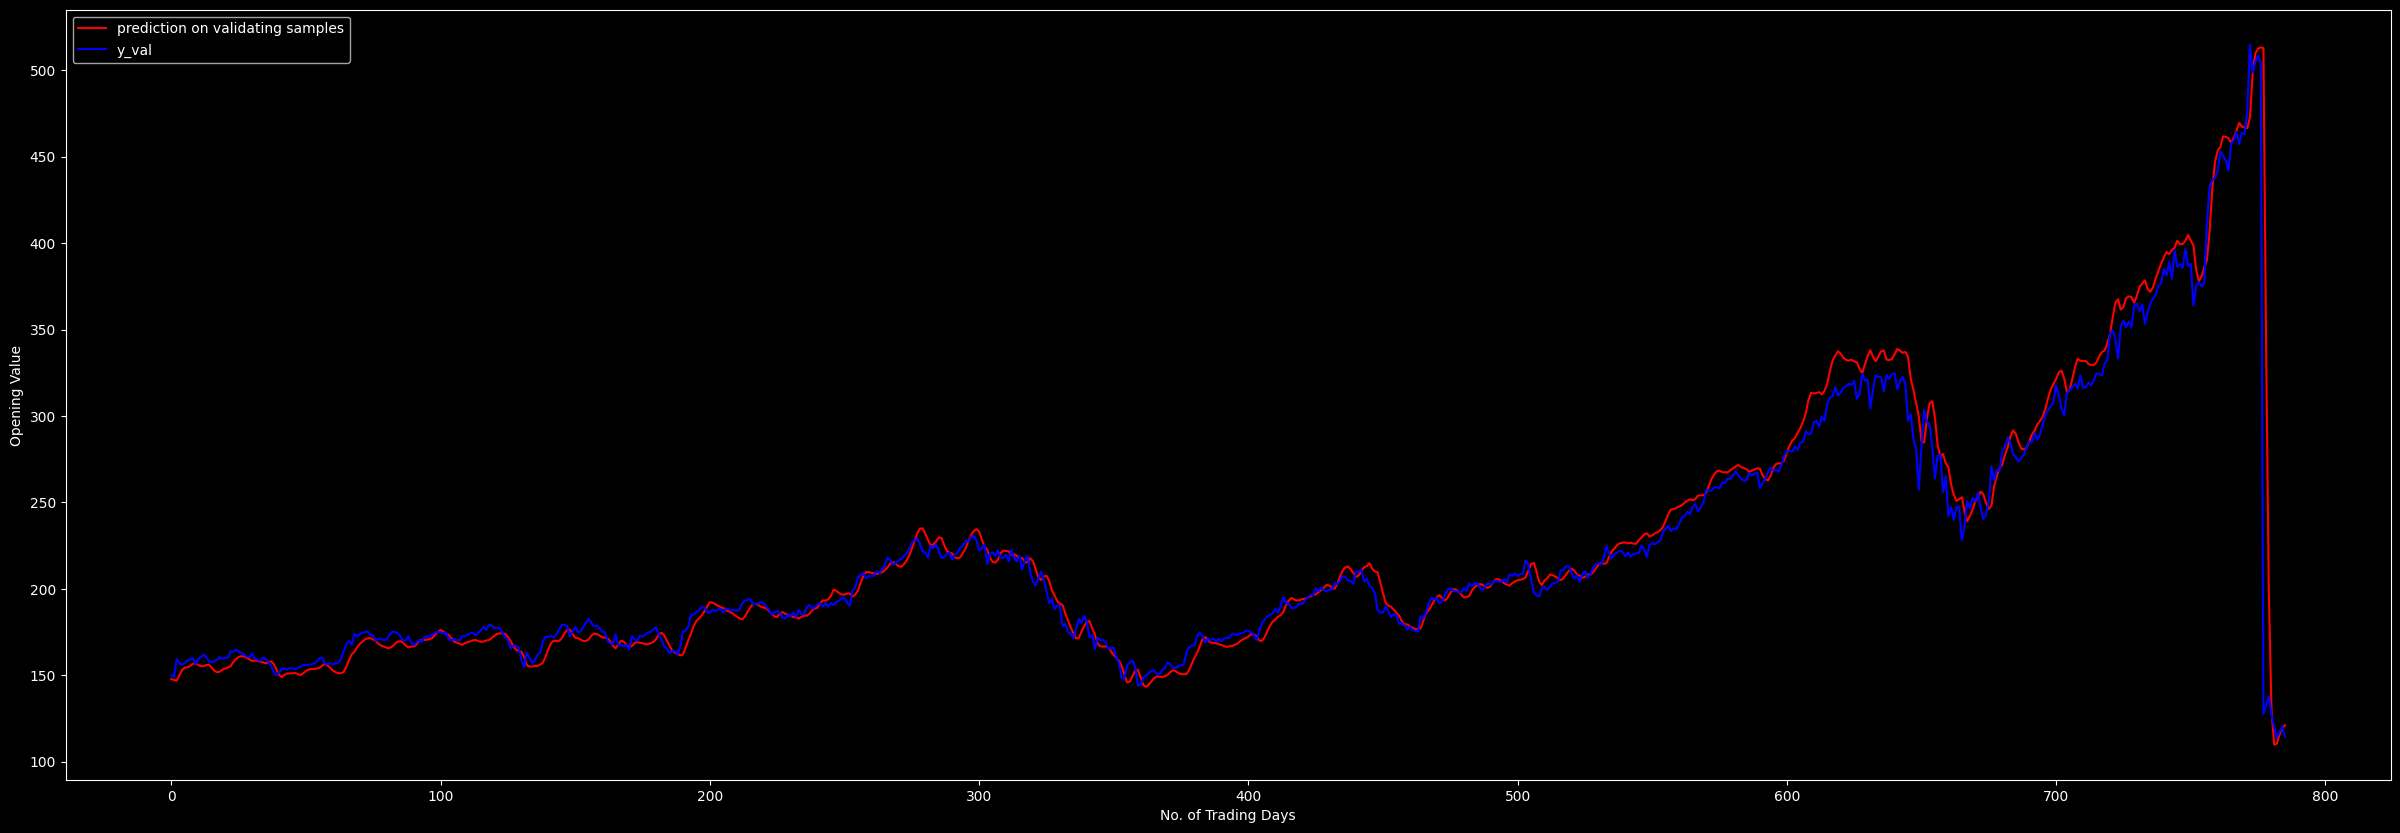

In [57]:
# Compare p_val and y_val
plt.plot(p_val, color='red', label='prediction on validating samples')
plt.plot(sc_train.inverse_transform(y_val.reshape((-1, 1))), color='blue', label='y_val')
plt.xlabel('No. of Trading Days')
plt.ylabel('Opening Value')
plt.legend(loc='upper left')
fig = plt.gcf()
fig.set_size_inches(30,10)
plt.show()

## Prediction on Testing Dataset

In [58]:
# Scale training set open
sc_test = MinMaxScaler()
testing_set[:, 0] = sc_test.fit_transform(testing_set[:, 0].reshape((-1,1))).reshape((-1))

# Get X and y from training set
X_test, y_test = get_x_y(testing_set, 14, 0, 2)
print("X_test: ", X_test.shape)
print("y_test: ", y_test.shape)

X_test:  (913, 14, 2)
y_test:  (913,)


In [59]:
# Predict X_test
p_test = model.predict(X_test)
p_test = sc_test.inverse_transform(p_test)

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


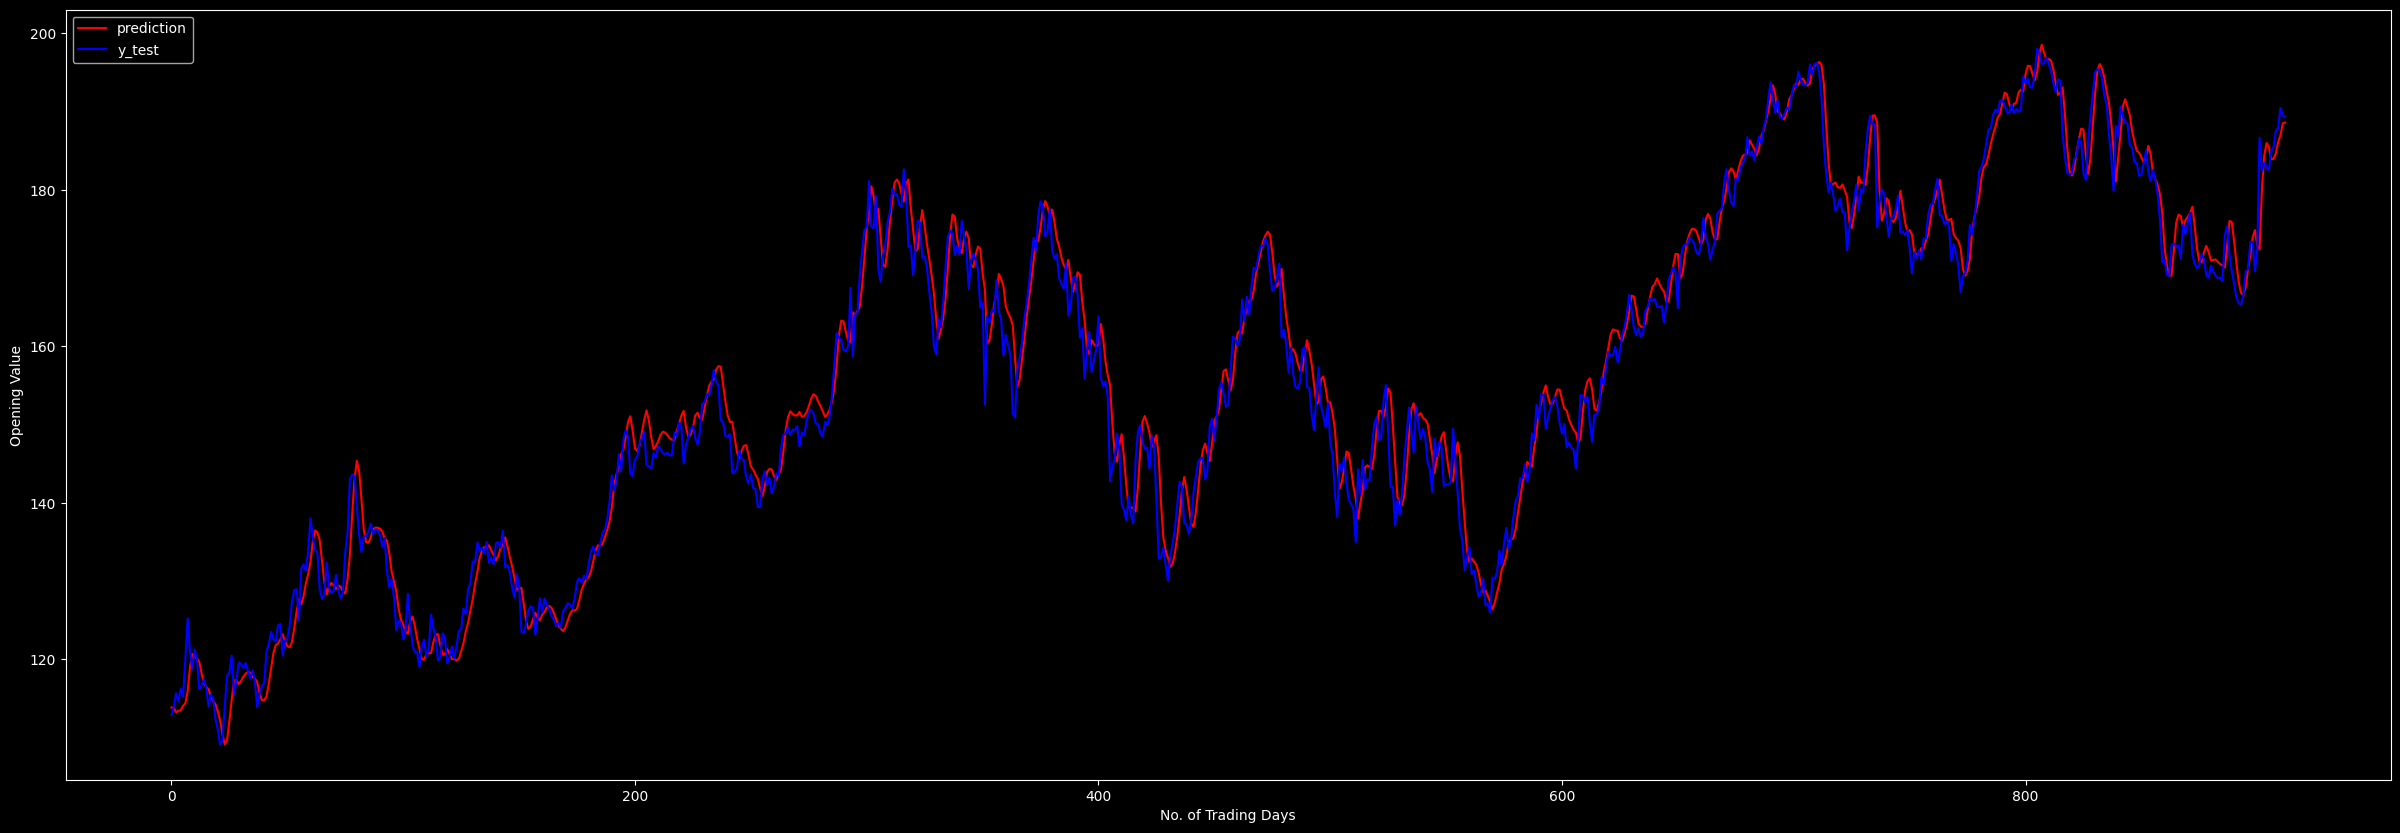

In [60]:
# Compare prediction vs y_test
plt.plot(p_test,color='red', label='prediction')
plt.plot(sc_test.inverse_transform(y_test.reshape((-1, 1))),color='blue', label='y_test')
plt.xlabel('No. of Trading Days')
plt.ylabel('Opening Value')
plt.legend(loc='upper left')
fig = plt.gcf()
fig.set_size_inches(30, 10)
plt.show()

## More Model Evaluation

In [61]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013 - mae: 0.0273
test loss, test acc: [0.0012789162574335933, 0.027605554088950157]


In [62]:
#adding empirical mae

from sklearn.metrics import mean_absolute_error
denomarlized_ytest = sc_test.inverse_transform(y_test.reshape((-1, 1)))
mae = mean_absolute_error(denomarlized_ytest, p_test)
mae_percentage = (mae / np.mean(denomarlized_ytest)) * 100
print("Mean absolute error on test set: {:.2f}%".format(mae_percentage))

Mean absolute error on test set: 1.65%


In [63]:
# r2 score
from sklearn.metrics import r2_score

# Actual values
actual = denomarlized_ytest

# Predicted values
predicted = p_test

# Calculate the R2 score
r2 = r2_score(actual, predicted)

print("R2 score:", r2)

R2 score: 0.9767171803609879


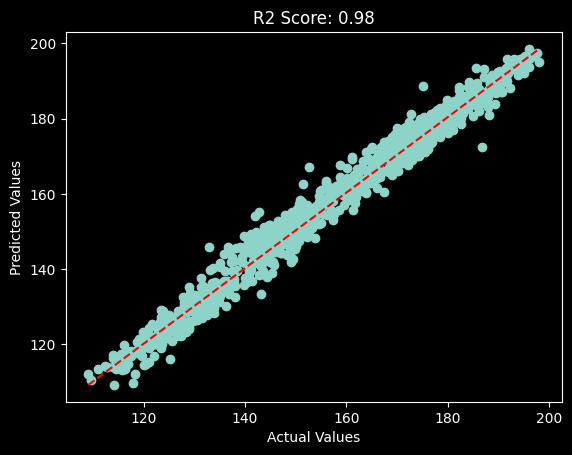

In [64]:
plt.scatter(actual, predicted)
plt.plot([min(actual), max(actual)], [min(predicted), max(predicted)], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'R2 Score: {r2:.2f}')
plt.show()

# With Sentiment - Missing Sentiment Scores have Average of Nearest 2 Days - 2015 Onward

## Data Preprocessing

In [66]:
BERT_sent_data = pd.read_csv('data/4.12.15-5.11.24_BERT_sentiments.csv')

In [67]:
# Convert 'timestamp' to datetime
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Filter out stock data with timestamp < 2015-04-14
stock_data = data[(data['timestamp'] >= '2015-04-14') & (data['timestamp'] <= '2024-05-09')]

stock_data

,timestamp,open,high,low,close,volume
2291,2015-04-14,127.000,127.29,125.91,126.30,25524593
2290,2015-04-15,126.410,127.13,126.01,126.78,28970419
2289,2015-04-16,126.280,127.10,126.11,126.17,28368987
2288,2015-04-17,125.550,126.14,124.46,124.75,51957046
2287,2015-04-20,125.570,128.12,125.17,127.60,47054310
...,...,...,...,...,...,...
11,2024-05-03,186.645,187.00,182.66,183.38,163224109
10,2024-05-06,182.354,184.20,180.42,181.71,78569667
9,2024-05-07,183.450,184.90,181.32,182.40,77305771
8,2024-05-08,182.850,183.07,181.45,182.74,45057087


In [68]:
# Convert 'date' to datetime
BERT_sent_data['date'] = pd.to_datetime(BERT_sent_data['date'])

# Merge data on dates
merged_data = pd.merge(stock_data, BERT_sent_data, left_on='timestamp', right_on='date', how='left')

# Sort by date to ensure correct order
merged_data['timestamp'] = pd.to_datetime(merged_data['timestamp'])
merged_data.sort_values('timestamp', inplace=True)

# Fill NaN dates with corresponding timestamps
merged_data['date'] = merged_data['date'].fillna(merged_data['timestamp'])

# Combine article titles of the two closest days into a list for rows with unknown sentiment
def combine_titles(row):
    if pd.isna(row['sentiment']):
        prev_titles = merged_data.iloc[row.name - 1]['article_titles'] if row.name > 0 else []
        next_titles = merged_data.iloc[row.name + 1]['article_titles'] if row.name < len(merged_data) - 1 else []
        if not pd.isna(merged_data.iloc[row.name - 1]['article_titles']) and not pd.isna(merged_data.iloc[row.name + 1]['article_titles']):
          return prev_titles + next_titles
        elif not not pd.isna(merged_data.iloc[row.name + 1]['article_titles']):
          return next_titles
        else:
          return prev_titles
    else:
        return row['article_titles']

merged_data['article_titles'] = merged_data.apply(combine_titles, axis=1)

unknown_sentiment_indices = merged_data[merged_data['sentiment'].isna()].index
for idx in unknown_sentiment_indices:
    # Get sentiment values of the closest two rows with known sentiment
    prev_sentiment = merged_data.iloc[idx - 1]['sentiment']
    next_sentiment = merged_data.iloc[idx + 1]['sentiment']
    # Calculate average sentiment
    avg_sentiment = (prev_sentiment + next_sentiment) / 2
    # Update sentiment value for the current row
    merged_data.at[idx, 'sentiment'] = avg_sentiment

# Fill any remaining missing sentiment values with forward fill and backward fill
merged_data['sentiment'] = merged_data['sentiment'].fillna(method='ffill').fillna(method='bfill')

merged_data

C:\Users\blkeu\AppData\Local\Temp\ipykernel_34672\1675482586.py:41: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_data['sentiment'] = merged_data['sentiment'].fillna(method='ffill').fillna(method='bfill')


,timestamp,open,high,low,close,volume,date,article_titles,sentiment
0,2015-04-14,127.000,127.29,125.91,126.30,25524593,2015-04-14,"['Will The $17,000 Apple Watch Inspire A $20,0...",-0.51970
1,2015-04-15,126.410,127.13,126.01,126.78,28970419,2015-04-15,['6% Of US Adults Plan To Purchase Apple Watch...,-0.71270
2,2015-04-16,126.280,127.10,126.11,126.17,28368987,2015-04-16,['6% Of US Adults Plan To Purchase Apple Watch...,-0.46950
3,2015-04-17,125.550,126.14,124.46,124.75,51957046,2015-04-17,['Apple Offers Workshops For Users To Get Acqu...,-0.22630
4,2015-04-20,125.570,128.12,125.17,127.60,47054310,2015-04-20,"['2 Apple Charts This Expert Is Tracking', ""Wh...",-0.23380
...,...,...,...,...,...,...,...,...,...
2280,2024-05-03,186.645,187.00,182.66,183.38,163224109,2024-05-03,"['Canaccord Genuity Maintains Buy on Apple, Ra...",-0.38650
2281,2024-05-06,182.354,184.20,180.42,181.71,78569667,2024-05-06,"['Thanks To Apple, This Analyst Is Optimistic ...",-0.01730
2282,2024-05-07,183.450,184.90,181.32,182.40,77305771,2024-05-07,"['Thanks To Apple, This Analyst Is Optimistic ...",-0.29645
2283,2024-05-08,182.850,183.07,181.45,182.74,45057087,2024-05-08,['Apple Reverses Sales Decline in China with I...,-0.57560


In [69]:
# Split data into training and testing
training_set, testing_set = split_data(merged_data, 0.85, ['open', 'sentiment'])
print("training_set: ", training_set.shape)
print("testing_set: ", testing_set.shape)

training_set:  (1942, 2)
testing_set:  (343, 2)


In [70]:
# Scale training set open
from sklearn.preprocessing import MinMaxScaler
sc_train = MinMaxScaler()
training_set[:, 0] = sc_train.fit_transform(training_set[:, 0].reshape((-1,1))).reshape((-1))
training_set[:5]

array([[ 0.08710186, -0.5197    ],
       [ 0.08571294, -0.7127    ],
       [ 0.08540691, -0.4695    ],
       [ 0.08368841, -0.2263    ],
       [ 0.08373549, -0.2338    ]])

In [71]:
# Get X and y from training set
X_train, y_train = get_x_y(training_set, 14, 0, 2)

# Split training into train and val
val_split_row = int(X_train.shape[0]*0.85) # 15% will be used for validation
X_train, X_val = X_train[:val_split_row], X_train[val_split_row:]
y_train, y_val = y_train[:val_split_row], y_train[val_split_row:]
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_val: ", X_val.shape)
print("y_val: ", y_val.shape)

X_train:  (1638, 14, 2)
y_train:  (1638,)
X_val:  (290, 14, 2)
y_val:  (290,)


## LSTM Model and Training

In [72]:
model = build_model(14, 2)
print(model.summary())

C:\Users\blkeu\anaconda3\envs\CS172B311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 14, 128)             │          67,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 32)                  │          20,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 88,225 (344.63 KB)

 Trainable params: 88,225 (344.63 KB)

 Non-trainable params: 0 (0.00 B)

None


In [74]:
# # Save weights only for best model
# checkpointer = ModelCheckpoint(
#     filepath = 'weights_best.pth',
#     verbose = 2,
#     save_best_only = True
# )


history = model.fit(X_train,
                    y_train,
                    batch_size=32,
                    epochs=25,
                    validation_data=(X_val, y_val),
                    verbose =2,
                    # callbacks = [checkpointer]
                   )

Epoch 1/25
52/52 - 3s - 50ms/step - loss: 0.0352 - mae: 0.1331 - val_loss: 7.9639e-04 - val_mae: 0.0227
Epoch 2/25
52/52 - 0s - 7ms/step - loss: 0.0071 - mae: 0.0452 - val_loss: 5.7635e-04 - val_mae: 0.0191
Epoch 3/25
52/52 - 0s - 7ms/step - loss: 0.0040 - mae: 0.0308 - val_loss: 3.1937e-04 - val_mae: 0.0151
Epoch 4/25
52/52 - 0s - 6ms/step - loss: 0.0032 - mae: 0.0274 - val_loss: 2.9306e-04 - val_mae: 0.0143
Epoch 5/25
52/52 - 0s - 6ms/step - loss: 0.0025 - mae: 0.0253 - val_loss: 2.7409e-04 - val_mae: 0.0140
Epoch 6/25
52/52 - 0s - 7ms/step - loss: 0.0027 - mae: 0.0280 - val_loss: 4.1082e-04 - val_mae: 0.0164
Epoch 7/25
52/52 - 0s - 7ms/step - loss: 0.0030 - mae: 0.0274 - val_loss: 3.6888e-04 - val_mae: 0.0155
Epoch 8/25
52/52 - 0s - 8ms/step - loss: 0.0025 - mae: 0.0222 - val_loss: 2.2527e-04 - val_mae: 0.0125
Epoch 9/25
52/52 - 0s - 7ms/step - loss: 0.0018 - mae: 0.0196 - val_loss: 2.0263e-04 - val_mae: 0.0118
Epoch 10/25
52/52 - 0s - 7ms/step - loss: 0.0018 - mae: 0.0195 - val_los

## Model Evaluation

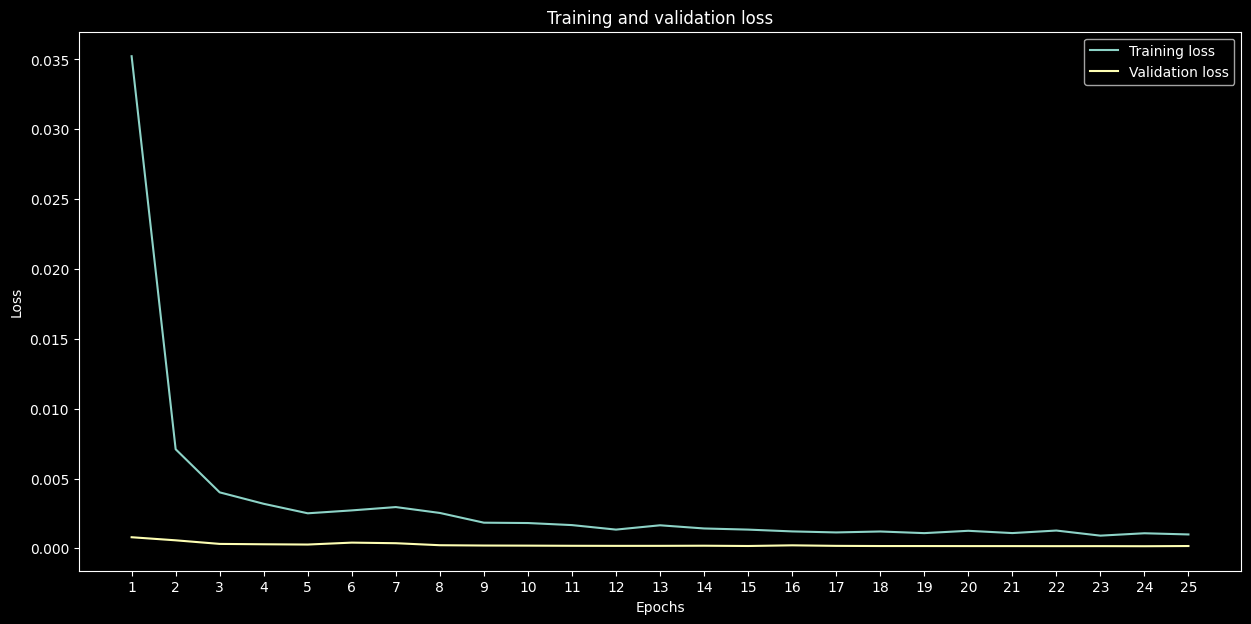

In [75]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values)+1)
plt.plot(epochs, loss_values, label='Training loss')
plt.plot(epochs, val_loss_values, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.xticks(epochs)
fig = plt.gcf()
fig.set_size_inches(15,7)
plt.show()

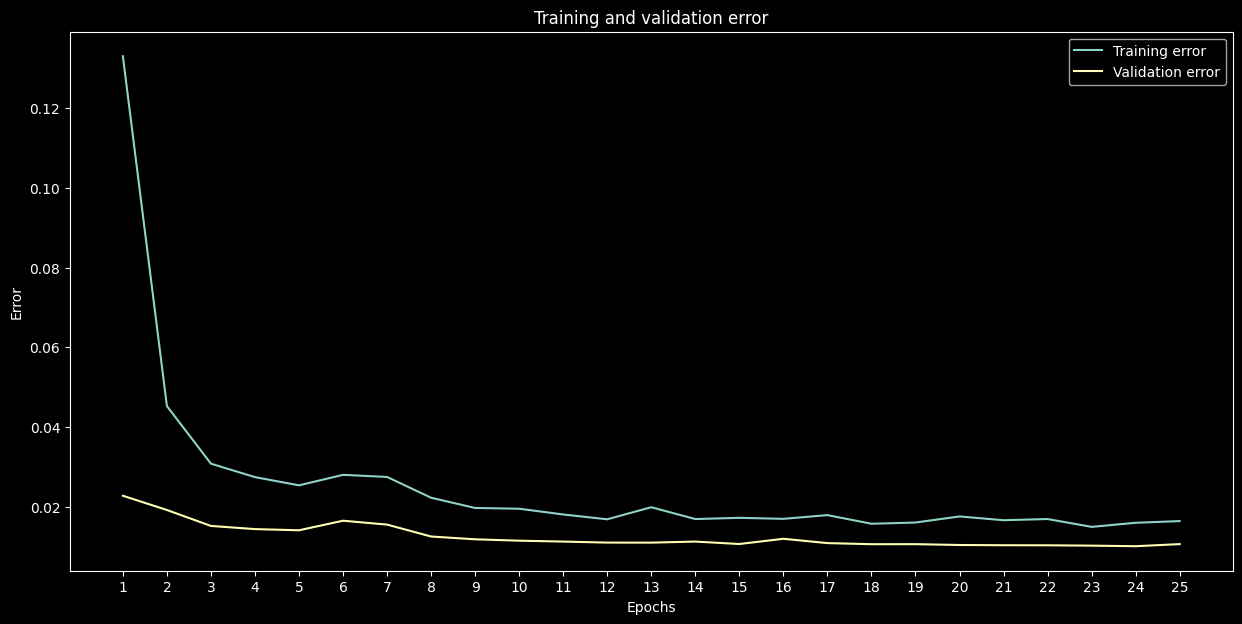

In [76]:
mae = history_dict['mae']
val_mae = history_dict['val_mae']
plt.plot(epochs, mae, label='Training error')
plt.plot(epochs, val_mae, label='Validation error')
plt.title('Training and validation error')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.xticks(epochs)
fig = plt.gcf()
fig.set_size_inches(15,7)
plt.show()

In [77]:
# Predict X_train and X_val
p_train = model.predict(X_train)
p_train = sc_train.inverse_transform(p_train)
p_val = model.predict(X_val)
p_val = sc_train.inverse_transform(p_val)

52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


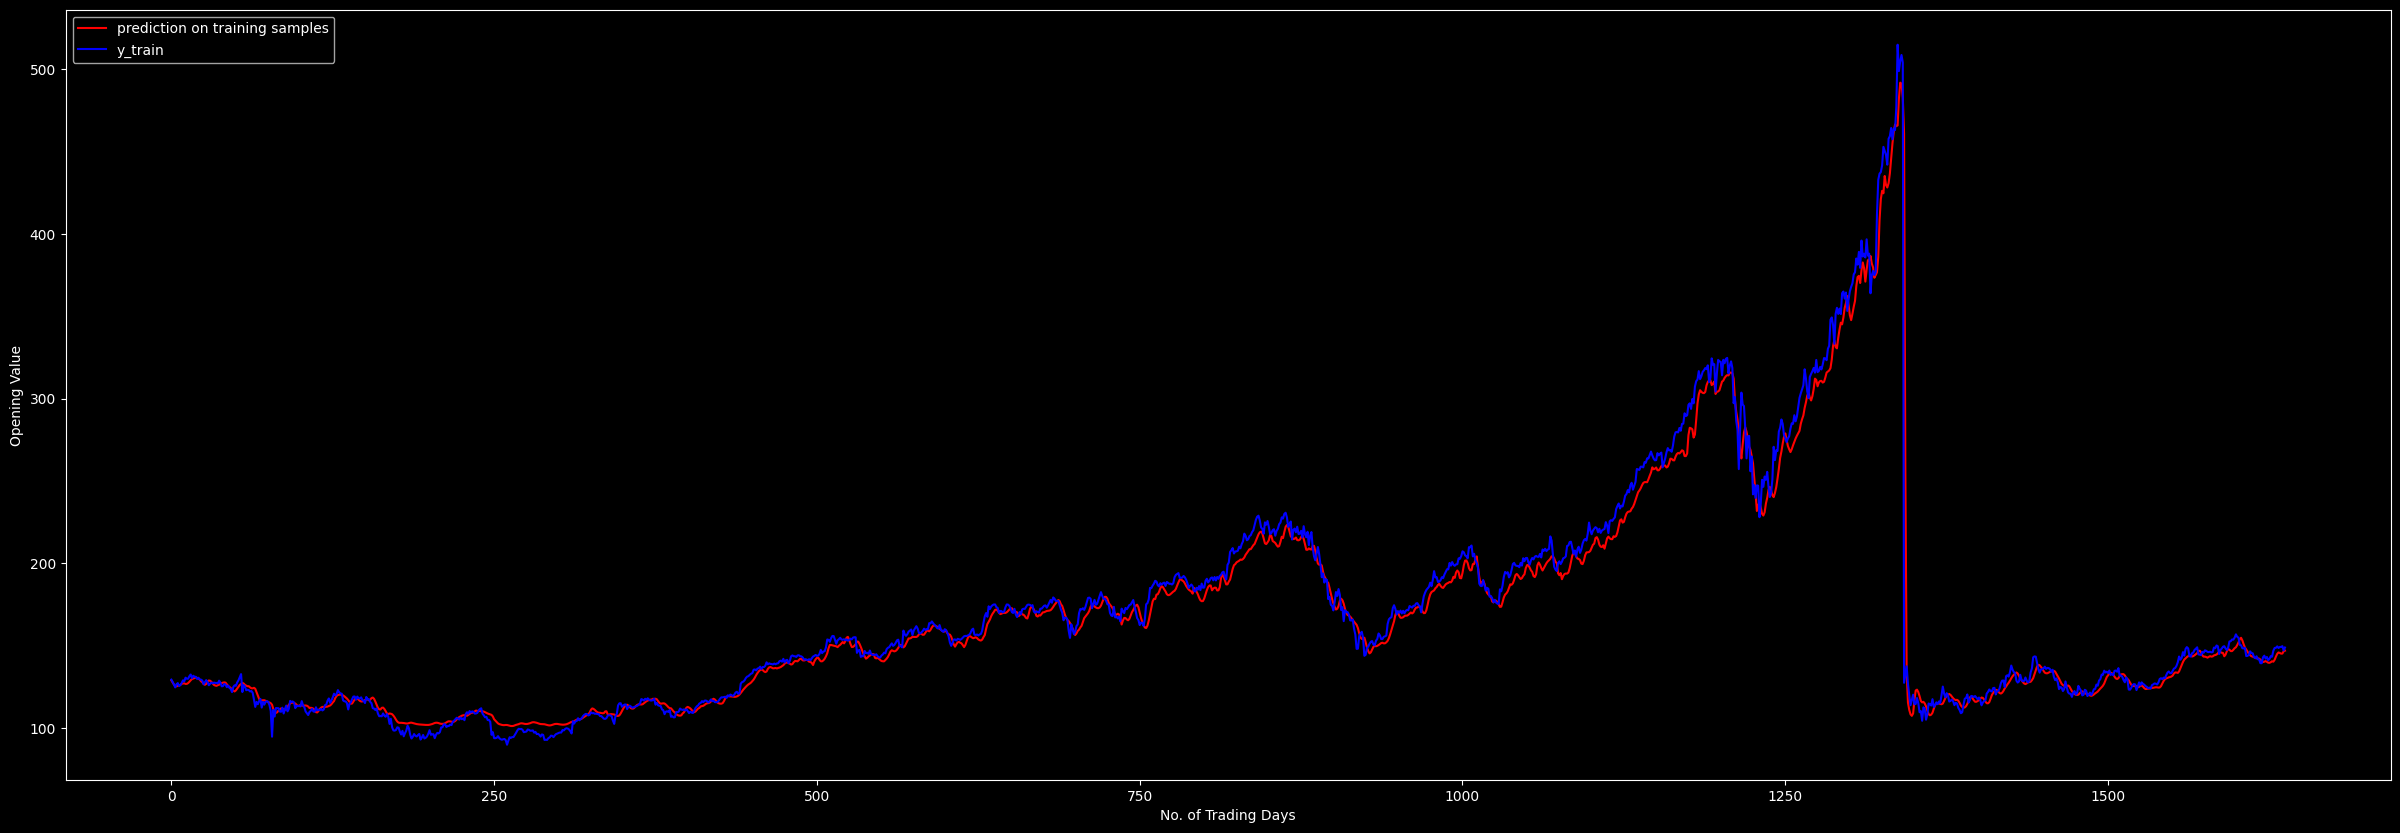

In [78]:
# Compare p_train and y_train
plt.plot(p_train, color='red', label='prediction on training samples')
plt.plot(sc_train.inverse_transform(y_train.reshape((-1, 1))), color='blue', label='y_train')
plt.xlabel('No. of Trading Days')
plt.ylabel('Opening Value')
plt.legend(loc='upper left')
fig = plt.gcf()
fig.set_size_inches(30,10)
plt.show()

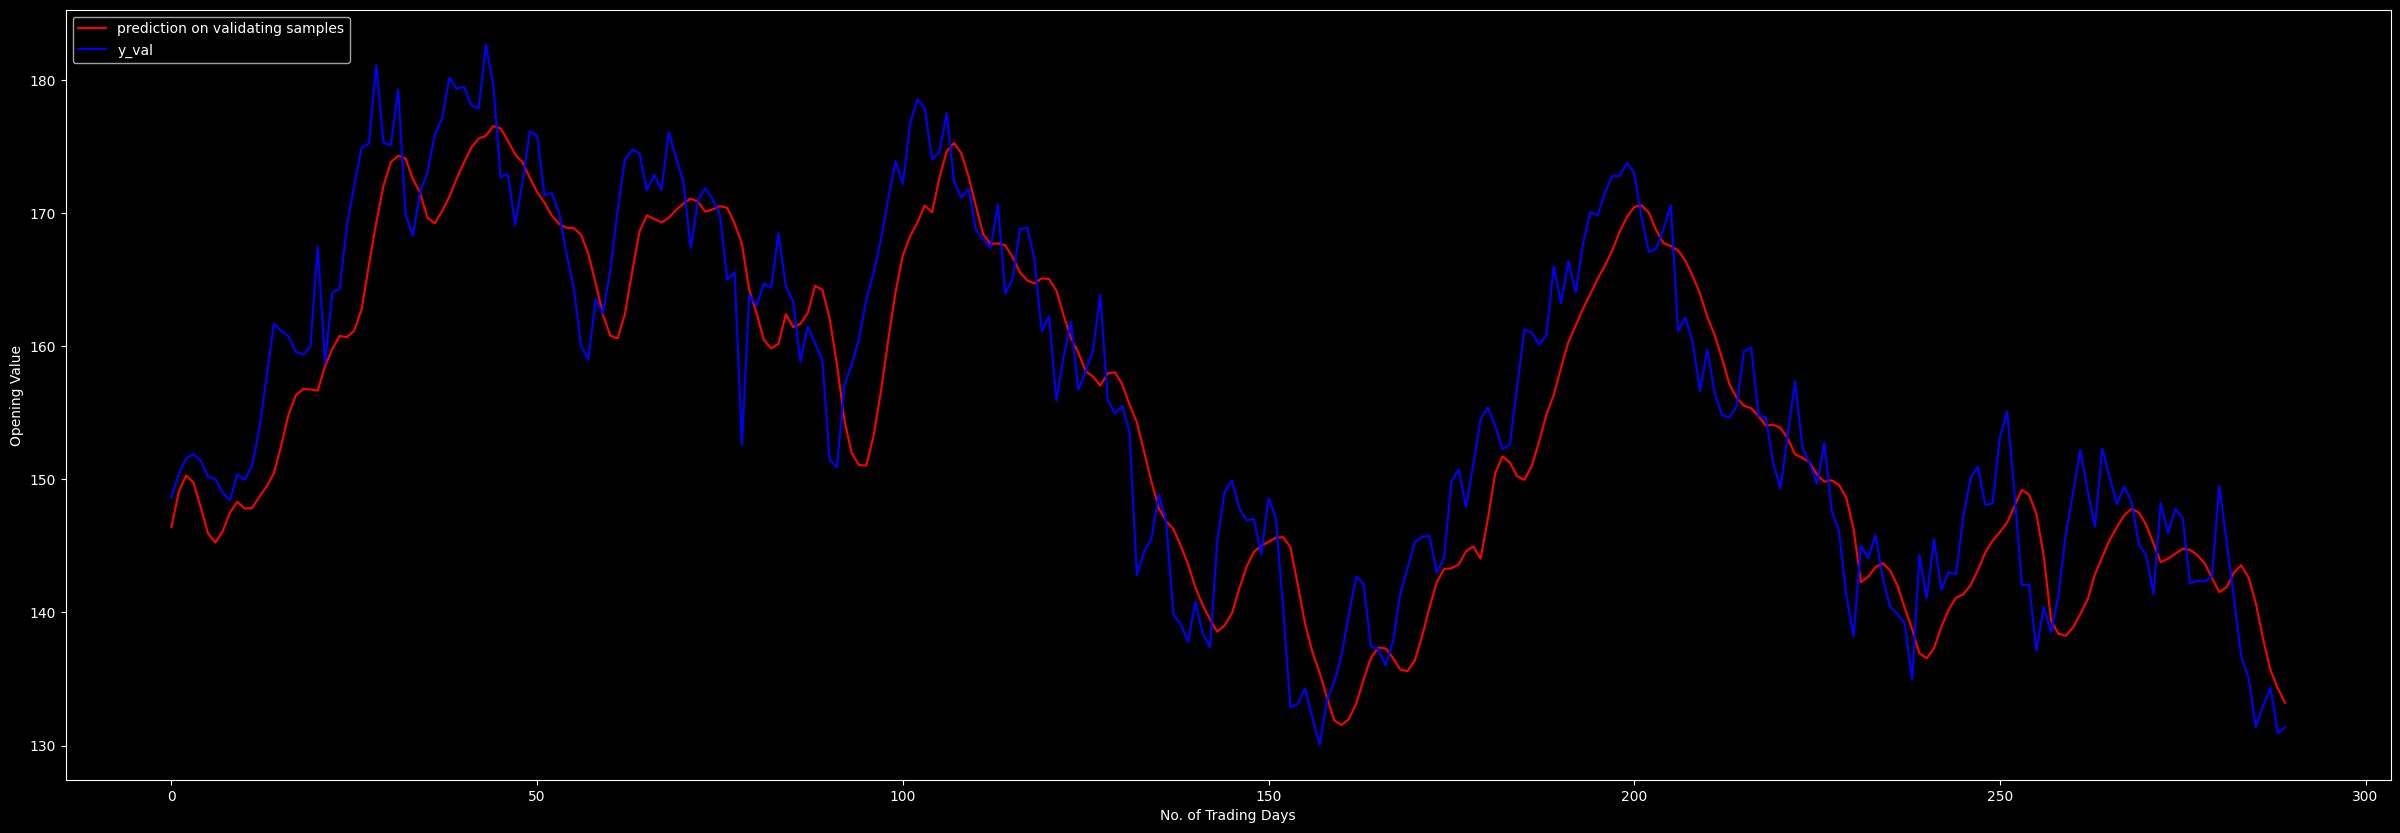

In [79]:
# Compare p_val and y_val
plt.plot(p_val, color='red', label='prediction on validating samples')
plt.plot(sc_train.inverse_transform(y_val.reshape((-1, 1))), color='blue', label='y_val')
plt.xlabel('No. of Trading Days')
plt.ylabel('Opening Value')
plt.legend(loc='upper left')
fig = plt.gcf()
fig.set_size_inches(30,10)
plt.show()

## Prediction on Testing Dataset

In [80]:
# Scale training set open
sc_test = MinMaxScaler()
testing_set[:, 0] = sc_test.fit_transform(testing_set[:, 0].reshape((-1,1))).reshape((-1))

# Get X and y from training set
X_test, y_test = get_x_y(testing_set, 14, 0, 2)
print("X_test: ", X_test.shape)
print("y_test: ", y_test.shape)

X_test:  (329, 14, 2)
y_test:  (329,)


In [81]:
# Predict X_test
p_test = model.predict(X_test)
p_test = sc_test.inverse_transform(p_test)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


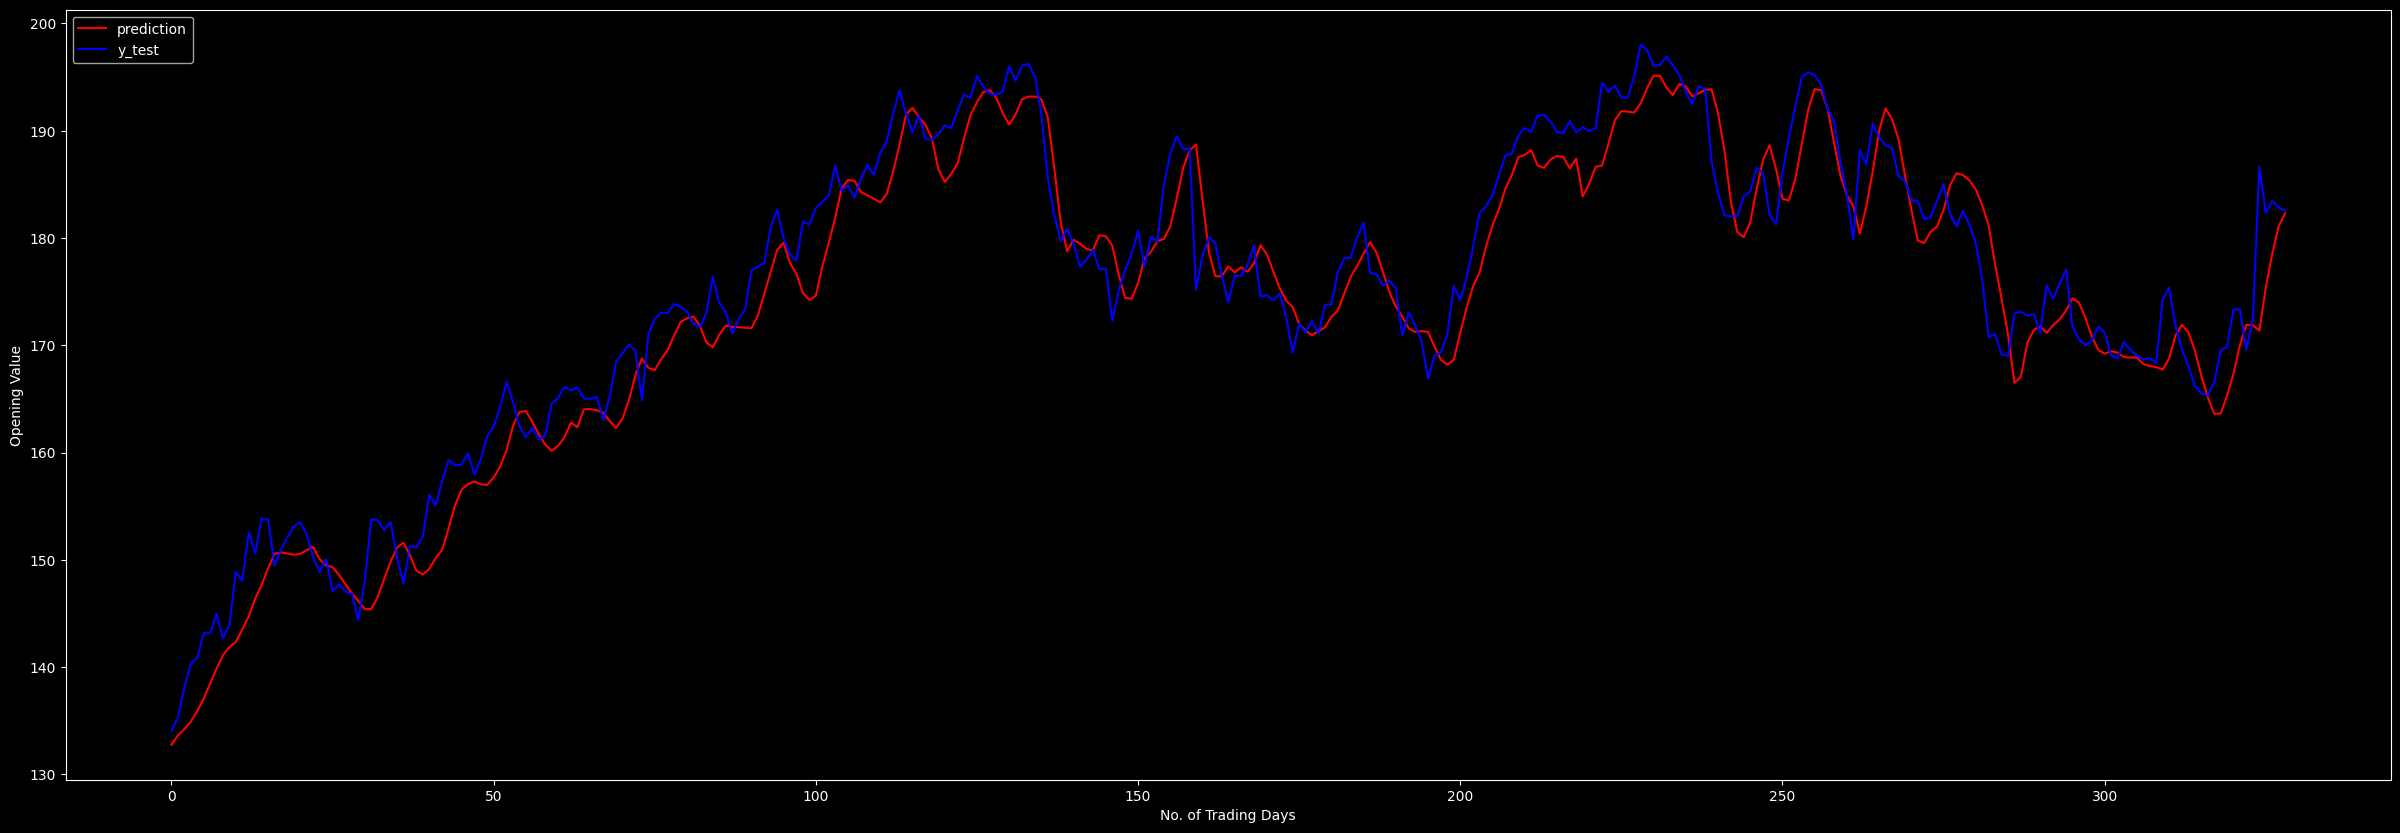

In [82]:
# Compare prediction vs y_test
plt.plot(p_test,color='red', label='prediction')
plt.plot(sc_test.inverse_transform(y_test.reshape((-1, 1))),color='blue', label='y_test')
plt.xlabel('No. of Trading Days')
plt.ylabel('Opening Value')
plt.legend(loc='upper left')
fig = plt.gcf()
fig.set_size_inches(30, 10)
plt.show()

## More Model Evaluation

In [83]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0027 - mae: 0.0427 
test loss, test acc: [0.0027504931204020977, 0.042036719620227814]


In [84]:
#adding empirical mae

from sklearn.metrics import mean_absolute_error
denomarlized_ytest = sc_test.inverse_transform(y_test.reshape((-1, 1)))
mae = mean_absolute_error(denomarlized_ytest, p_test)
mae_percentage = (mae / np.mean(denomarlized_ytest)) * 100
print("Mean absolute error on test set: {:.2f}%".format(mae_percentage))

Mean absolute error on test set: 1.73%


In [85]:
# r2 score
from sklearn.metrics import r2_score

# Actual values
actual = denomarlized_ytest

# Predicted values
predicted = p_test

# Calculate the R2 score
r2 = r2_score(actual, predicted)

print("R2 score:", r2)

R2 score: 0.9268500828300045


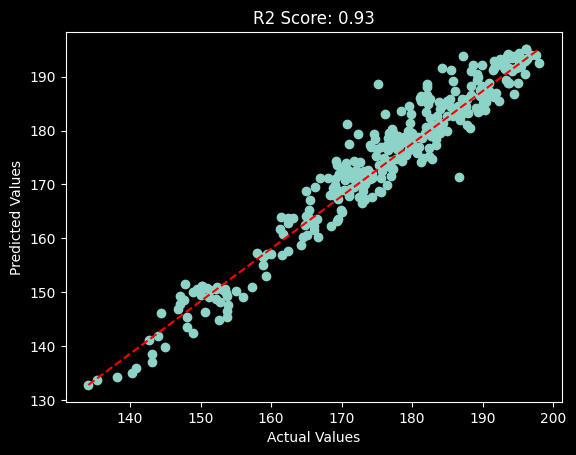

In [86]:
plt.scatter(actual, predicted)
plt.plot([min(actual), max(actual)], [min(predicted), max(predicted)], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'R2 Score: {r2:.2f}')
plt.show()